In [1]:
# STEP 1: DYNAMIC FILE DETECTION AND COLUMN CONSISTENCY CHECK
print("SCORESIGHT - EPL DATA ANALYSIS")
print("=" * 50)
print("STEP 1: Dynamic File Detection and Column Consistency Check")
print("=" * 50)

import pandas as pd
import numpy as np
import os
import glob

# Dynamically find all season CSV files
print("Searching for season files...")
season_files = glob.glob("season-*.csv")
print(f"Found {len(season_files)} season files")

# Extract seasons from filenames
seasons = []
for file in season_files:
    # Extract season name from filename (e.g., "2010-2011" from "season-2010-2011.csv")
    season_name = file.replace('season-', '').replace('.csv', '')
    seasons.append(season_name)

seasons.sort()  # Sort chronologically
print(f"Seasons detected: {seasons}")

# Check each file and its columns
all_columns_info = {}

for season in seasons:
    filename = f"season-{season}.csv"
    
    if os.path.exists(filename):
        # Load the CSV
        df = pd.read_csv(filename)
        
        # Store column information
        all_columns_info[season] = {
            'columns': list(df.columns),
            'total_columns': len(df.columns),
            'total_rows': len(df),
            'sample_data': df.head(2)  # First 2 rows for preview
        }
        
        print(f"{filename}: {len(df.columns)} columns, {len(df)} rows")
    else:
        print(f"{filename}: File not found")
        all_columns_info[season] = None

print(f"\nTotal seasons available for processing: {len([s for s in seasons if all_columns_info[s] is not None])}")

SCORESIGHT - EPL DATA ANALYSIS
STEP 1: Dynamic File Detection and Column Consistency Check
Searching for season files...
Found 10 season files
Seasons detected: ['2010-2011', '2011-2012', '2012-2013', '2013-2014', '2014-2015', '2015-2016', '2016-2017', '2017-2018', '2018-2019', '2019-2020']
season-2010-2011.csv: 71 columns, 380 rows
season-2011-2012.csv: 71 columns, 380 rows
season-2012-2013.csv: 74 columns, 380 rows
season-2013-2014.csv: 68 columns, 380 rows
season-2014-2015.csv: 68 columns, 380 rows
season-2015-2016.csv: 65 columns, 380 rows
season-2016-2017.csv: 65 columns, 380 rows
season-2017-2018.csv: 65 columns, 380 rows
season-2018-2019.csv: 62 columns, 380 rows
season-2019-2020.csv: 106 columns, 209 rows

Total seasons available for processing: 10


Key Observations:

10 seasons successfully detected (2010-2011 to 2019-2020)

Varying column counts: Ranging from 62 to 106 columns across seasons

Most seasons: 380-381 rows (typical EPL season with 20 teams playing 38 games each)

2019-2020 season: Only 209 rows (likely incomplete data due to COVID-19)

Important Finding: Column counts vary significantly (62 to 106), which means we have different metrics tracked across seasons.

In [2]:
# STEP 2: COLUMN ANALYSIS AND COMMON COLUMNS IDENTIFICATION
print("STEP 2: Column Analysis and Common Columns Identification")
print("=" * 60)

# Get all unique column names across all seasons
all_columns = set()
for season, info in all_columns_info.items():
    if info is not None:
        all_columns.update(info['columns'])

print(f"Total unique columns across all seasons: {len(all_columns)}")

# Find columns common to ALL seasons
common_columns = set(all_columns_info[seasons[0]]['columns'])
for season in seasons[1:]:
    if all_columns_info[season] is not None:
        common_columns = common_columns.intersection(set(all_columns_info[season]['columns']))

print(f"Columns common to ALL seasons: {len(common_columns)}")
print("Common columns:", sorted(common_columns))

# Find columns that appear in most seasons (at least 8 out of 10)
column_frequency = {}
for column in all_columns:
    count = 0
    for season in seasons:
        if all_columns_info[season] is not None and column in all_columns_info[season]['columns']:
            count += 1
    column_frequency[column] = count

# Columns present in at least 8 seasons
frequent_columns = {col: freq for col, freq in column_frequency.items() if freq >= 8}
print(f"\nColumns present in at least 8 seasons: {len(frequent_columns)}")

# Display column frequency summary
print("\nColumn Frequency Summary:")
print("Frequency | Count of Columns")
print("-" * 30)
for freq in sorted(set(column_frequency.values()), reverse=True):
    count = len([col for col, f in column_frequency.items() if f == freq])
    print(f"{freq:9} | {count:16}")

# Show sample of columns that appear in only few seasons
rare_columns = {col: freq for col, freq in column_frequency.items() if freq <= 3}
print(f"\nColumns appearing in 3 or fewer seasons: {len(rare_columns)}")
if rare_columns:
    print("Sample rare columns:", list(rare_columns.keys())[:10])

STEP 2: Column Analysis and Common Columns Identification
Total unique columns across all seasons: 139
Columns common to ALL seasons: 38
Common columns: ['AC', 'AF', 'AR', 'AS', 'AST', 'AY', 'AwayTeam', 'B365A', 'B365D', 'B365H', 'BWA', 'BWD', 'BWH', 'Date', 'Div', 'FTAG', 'FTHG', 'FTR', 'HC', 'HF', 'HR', 'HS', 'HST', 'HTAG', 'HTHG', 'HTR', 'HY', 'HomeTeam', 'IWA', 'IWD', 'IWH', 'Referee', 'VCA', 'VCD', 'VCH', 'WHA', 'WHD', 'WHH']

Columns present in at least 8 seasons: 65

Column Frequency Summary:
Frequency | Count of Columns
------------------------------
       10 |               38
        9 |               18
        8 |                9
        5 |                3
        3 |                6
        2 |                3
        1 |               62

Columns appearing in 3 or fewer seasons: 71
Sample rare columns: ['MaxD', 'WHCH', 'AvgCAHA', 'WHCD', 'AvgH', 'MaxCA', 'SBD', 'P>2.5', 'MaxCD', 'MaxC>2.5']


We're merging all seasons while preserving all columns, adding season tracking, and categorizing columns by type (betting, match stats, teams). This handles varying column structures across seasons.

In [3]:
# Define a comprehensive mapping for column names to standardize them
# Keys are common variations (lowercase), values are the desired standardized names
column_standardization_map = {
    'div': 'Div',
    'date': 'Date',
    'hometeam': 'HomeTeam',
    'awayteam': 'AwayTeam',
    'full_time_home_goals': 'FTHG',
    'fthg': 'FTHG',
    'full_time_away_goals': 'FTAG',
    'ftag': 'FTAG',
    'full_time_result': 'FTR',
    'ftr': 'FTR',
    'half_time_home_goals': 'HTHG',
    'hthg': 'HTHG',
    'half_time_away_goals': 'HTAG',
    'htag': 'HTAG',
    'half_time_result': 'HTR',
    'htr': 'HTR',
    'referee': 'Referee',
    'home_shots': 'HS',
    'hs': 'HS',
    'away_shots': 'AS',
    'as': 'AS',
    'home_shots_on_target': 'HST',
    'hst': 'HST',
    'away_shots_on_target': 'AST',
    'ast': 'AST',
    'home_fouls': 'HF',
    'hf': 'HF',
    'away_fouls': 'AF',
    'af': 'AF',
    'home_corners': 'HC',
    'hc': 'HC',
    'away_corners': 'AC',
    'ac': 'AC',
    'home_yellow_cards': 'HY',
    'hy': 'HY',
    'away_yellow_cards': 'AY',
    'ay': 'AY',
    'home_red_cards': 'HR',
    'hr': 'HR',
    'away_red_cards': 'AR',
    'ar': 'AR',
    'b365h': 'B365H',
    'b365d': 'B365D',
    'b365a': 'B365A',
    'bwh': 'BWH',
    'bwd': 'BWD',
    'bwa': 'BWA',
    'gbh': 'GBH',
    'gbd': 'GBD',
    'gba': 'GBA',
    'iwh': 'IWH',
    'iwd': 'IWD',
    'iwa': 'IWA',
    'lbh': 'LBH',
    'lbd': 'LBD',
    'lba': 'LBA',
    'sbh': 'SBH',
    'sbd': 'SBD',
    'sba': 'SBA',
    'whh': 'WHH',
    'whd': 'WHD',
    'wha': 'WHA',
    'sjh': 'SJH',
    'sjd': 'SJD',
    'sja': 'SJA',
    'vch': 'VCH',
    'vcd': 'VCD',
    'vca': 'VCA',
    'bsh': 'BSH',
    'bsd': 'BSD',
    'bsa': 'BSA',
    'bb1x2': 'Bb1X2',
    'bbmxh': 'BbMxH',
    'bbavh': 'BbAvH',
    'bbmxd': 'BbMxD',
    'bbavd': 'BbAvD',
    'bbmxa': 'BbMxA',
    'bbava': 'BbAvA',
    'bbou': 'BbOU',
    'bbmx>2.5': 'BbMx>2.5',
    'bbav>2.5': 'BbAv>2.5',
    'bbmx<2.5': 'BbMx<2.5',
    'bbav<2.5': 'BbAv<2.5',
    'bbah': 'BbAH',
    'bbahh': 'BbAHh',
    'bbmxahh': 'BbMxAHH',
    'bbavahh': 'BbAvAHH',
    'bbmxaha': 'BbMxAHA',
    'bbavaha': 'BbAvAHA',
    'psh': 'PSH',
    'psd': 'PSD',
    'psa': 'PSA',
    'maxh': 'MaxH',
    'maxd': 'MaxD',
    'maxa': 'MaxA',
    'avh': 'AvH',
    'avd': 'AvD',
    'ava': 'AvA',
    'p>2.5': 'P>2.5',
    'p<2.5': 'P<2.5',
    'gb>2.5': 'GB>2.5',
    'gb<2.5': 'GB<2.5',
    'b365>2.5': 'B365>2.5',
    'b365<2.5': 'B365<2.5',
    'vc>2.5': 'VC>2.5',
    'vc<2.5': 'VC<2.5',
    'wh>2.5': 'WH>2.5',
    'wh<2.5': 'WH<2.5',
    'iw>2.5': 'IW>2.5',
    'iw<2.5': 'IW<2.5',
    'lb>2.5': 'LB>2.5',
    'lb<2.5': 'LB<2.5',
    'sjb>2.5': 'SJB>2.5',
    'sjb<2.5': 'SJB<2.5',
    'bsca': 'BSCA',
    'bscr': 'BSCR',
    'bscy': 'BSCY',
    'b365ca': 'B365CA',
    'b365ch': 'B365CH',
    'b365cd': 'B365CD',
    'b365cahh': 'B365CAHH',
    'b365caha': 'B365CAHA',
    'bwca': 'BWCA',
    'bwch': 'BWCH',
    'bwcd': 'BWCD',
    'bwcahh': 'BWCAHH',
    'bwcaha': 'BWCAHA',
    'iwca': 'IWCA',
    'iwch': 'IWCH',
    'iwcd': 'IWCD',
    'iwcahh': 'IWCAHH',
    'iwcaha': 'IWCAHA',
    'vcca': 'VCCA',
    'vcch': 'VCCH',
    'vccd': 'VCCD',
    'vccahh': 'VCCAHH',
    'vccaha': 'VCCAHA',
    'whca': 'WHCA',
    'whch': 'WHCH',
    'whcd': 'WHCD',
    'whcahh': 'WHCAHH',
    'whcaha': 'WHCAHA',
    'psca': 'PSCA',
    'psch': 'PSCH',
    'pscd': 'PSCD',
    'pscahh': 'PSCAHH',
    'pscaha': 'PSCAHA',
    'avgch': 'AvgCH',
    'avgcd': 'AvgCD',
    'avgca': 'AvgCA',
    'avgcahh': 'AvgCAHH',
    'avgcaha': 'AvgCAHA',
    'avgc>2.5': 'AvgC>2.5',
    'avgc<2.5': 'AvgC<2.5',
    'maxcahh': 'MaxCAHH',
    'maxcaha': 'MaxCAHA',
    'pccahh': 'PCAHH',
    'pccaha': 'PCAHA',
    'pc>2.5': 'PC>2.5',
    'pc<2.5': 'PC<2.5',
    'b365c>2.5': 'B365C>2.5',
    'b365c<2.5': 'B365C<2.5',
    'lbch': 'LBCH',
    'lbcd': 'LBCD',
    'lbca': 'LBCA',
    'sjbch': 'SJBCH',
    'sjbcd': 'SJBCD',
    'sjbca': 'SJBCA',
}

# STEP 3: INTELLIGENT DATA MERGING STRATEGY
print("STEP 3: Intelligent Data Merging Strategy")
print("=" * 50)

def merge_epl_data_strategy(all_columns_info, seasons):
    """
    Merge strategy that preserves all columns while handling structural differences
    """
    all_dataframes = []
    
    for season in seasons:
        if all_columns_info[season] is not None:
            filename = f"season-{season}.csv"
            df = pd.read_csv(filename)
            
            # Standardize column names (FIXED INDENTATION)
            df.columns = df.columns.str.lower()
            df = df.rename(columns={col: column_standardization_map.get(col, col) for col in df.columns})
            
            # Add season column for tracking
            df['Season'] = season
            
            # Add season year for chronological analysis
            df['Season_Start_Year'] = int(season.split('-')[0])
            
            all_dataframes.append(df)
    
    # Use outer merge to preserve ALL columns from ALL seasons
    merged_df = pd.concat(all_dataframes, axis=0, ignore_index=True, sort=False)
    
    return merged_df

# Execute the merge
print("Merging all seasons while preserving all columns...")
final_merged_df = merge_epl_data_strategy(all_columns_info, seasons)

print("Merge completed!")
print(f"Final merged dataset shape: {final_merged_df.shape}")
print(f"Total rows: {final_merged_df.shape[0]:,}")
print(f"Total columns: {final_merged_df.shape[1]}")

# Display the structure of merged data
print("\nMerged Dataset Structure:")
print("=" * 40)
print(f"Seasons included: {final_merged_df['Season'].nunique()}")
print(f"Matches per season:")
matches_per_season = final_merged_df['Season'].value_counts().sort_index()
print(matches_per_season)

# Analyze column categories
print("\nColumn Categories Analysis:")
print("=" * 40)

# Identify different types of columns
all_columns = final_merged_df.columns.tolist()

# Categorize columns
betting_cols = [col for col in all_columns if any(x in col for x in ['B365', 'BW', 'IW', 'VC', 'WH'])]
match_stats_cols = [col for col in all_columns if col in ['FTHG', 'FTAG', 'HTHG', 'HTAG', 'HS', 'AS', 'HST', 'AST']]
team_cols = [col for col in all_columns if 'Team' in col]
referee_cols = [col for col in all_columns if 'Referee' in col]
other_cols = [col for col in all_columns if col not in betting_cols + match_stats_cols + team_cols + referee_cols + ['Season', 'Season_Start_Year']]

print(f"Betting columns: {len(betting_cols)}")
print(f"Match statistics columns: {len(match_stats_cols)}")
print(f"Team columns: {len(team_cols)}")
print(f"Referee columns: {len(referee_cols)}")
print(f"Other columns: {len(other_cols)}")

print(f"\nSample betting columns: {betting_cols[:10]}")
print(f"Sample match stats: {match_stats_cols}")
print(f"Team columns: {team_cols}")

STEP 3: Intelligent Data Merging Strategy
Merging all seasons while preserving all columns...
Merge completed!
Final merged dataset shape: (3629, 141)
Total rows: 3,629
Total columns: 141

Merged Dataset Structure:
Seasons included: 10
Matches per season:
Season
2010-2011    380
2011-2012    380
2012-2013    380
2013-2014    380
2014-2015    380
2015-2016    380
2016-2017    380
2017-2018    380
2018-2019    380
2019-2020    209
Name: count, dtype: int64

Column Categories Analysis:
Betting columns: 36
Match statistics columns: 8
Team columns: 2
Referee columns: 1
Other columns: 92

Sample betting columns: ['B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'WHH']
Sample match stats: ['FTHG', 'FTAG', 'HTHG', 'HTAG', 'HS', 'AS', 'HST', 'AST']
Team columns: ['HomeTeam', 'AwayTeam']


Step 4: Null Value Analysis
We're checking for missing values across all 141 columns, identifying patterns, and analyzing which seasons have the most data gaps. This helps us understand data quality issues.

In [4]:
# STEP 4: NULL VALUE ANALYSIS
print("STEP 4: Null Value Analysis")
print("=" * 40)

# Check null values across all columns
null_analysis = final_merged_df.isnull().sum()
null_percentage = (null_analysis / len(final_merged_df)) * 100

# Create comprehensive null summary
null_summary = pd.DataFrame({
    'Null_Count': null_analysis,
    'Null_Percentage': null_percentage
})

# Filter columns with null values only
columns_with_nulls = null_summary[null_summary['Null_Count'] > 0]
print(f"Columns with null values: {len(columns_with_nulls)} out of {len(final_merged_df.columns)}")
print(f"Total null values in dataset: {final_merged_df.isnull().sum().sum():,}")

# Display columns with highest null percentages
print("\nTop 20 columns with highest null percentages:")
high_null_cols = columns_with_nulls.sort_values('Null_Percentage', ascending=False).head(20)
print(high_null_cols)

# Analyze null patterns by season
print("\nNull values distribution by season:")
nulls_by_season = final_merged_df.groupby('Season').apply(lambda x: x.isnull().sum().sum())
print(nulls_by_season)

# Calculate data completeness by season
print("\nData completeness by season (% non-null):")
completeness_by_season = (1 - final_merged_df.groupby('Season').apply(lambda x: x.isnull().sum().sum() / (x.shape[0] * x.shape[1]))) * 100
print(completeness_by_season.round(2))

# Check specific important columns for nulls
key_columns = ['HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'B365H', 'B365D', 'B365A']
print(f"\nNull check for key prediction columns:")
for col in key_columns:
    if col in final_merged_df.columns:
        null_count = final_merged_df[col].isnull().sum()
        print(f"{col}: {null_count} nulls ({null_count/len(final_merged_df)*100:.2f}%)")

STEP 4: Null Value Analysis
Columns with null values: 107 out of 141
Total null values in dataset: 251,949

Top 20 columns with highest null percentages:
           Null_Count  Null_Percentage
maxcd            3420        94.240838
maxch            3420        94.240838
VCCA             3420        94.240838
VCCD             3420        94.240838
VCCH             3420        94.240838
WHCA             3420        94.240838
WHCD             3420        94.240838
WHCH             3420        94.240838
IWCA             3420        94.240838
PC>2.5           3420        94.240838
B365C<2.5        3420        94.240838
IWCH             3420        94.240838
IWCD             3420        94.240838
BWCA             3420        94.240838
BWCD             3420        94.240838
B365CD           3420        94.240838
B365CH           3420        94.240838
BWCH             3420        94.240838
B365CA           3420        94.240838
maxaha           3420        94.240838

Null values distribution b

C:\Users\Dia\AppData\Local\Temp\ipykernel_13712\366097371.py:27: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nulls_by_season = final_merged_df.groupby('Season').apply(lambda x: x.isnull().sum().sum())
C:\Users\Dia\AppData\Local\Temp\ipykernel_13712\366097371.py:32: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  completeness_by_season = (1 - final_merged_df.groupby('Season').apply(lambda x: x.isnull().sum().sum() / (

Step 5: Duplicate Row Analysis
We're checking for and removing duplicate rows to ensure data quality, while preserving the first occurrence of each unique match record.

In [5]:
# STEP 5: DUPLICATE ROW ANALYSIS AND CLEANING
print("STEP 5: Duplicate Row Analysis")
print("=" * 40)

# Check for duplicate rows
initial_row_count = len(final_merged_df)
duplicate_count = final_merged_df.duplicated().sum()

print(f"Initial dataset rows: {initial_row_count:,}")
print(f"Duplicate rows found: {duplicate_count}")
print(f"Percentage duplicates: {(duplicate_count/initial_row_count)*100:.2f}%")

if duplicate_count > 0:
    # Show sample of duplicate rows
    print("\nSample of duplicate rows:")
    duplicate_samples = final_merged_df[final_merged_df.duplicated(keep=False)].head(10)
    print(duplicate_samples[['Season', 'HomeTeam', 'AwayTeam', 'Date']].head())
    
    # Remove duplicates, keeping first occurrence
    final_merged_df = final_merged_df.drop_duplicates()
    
    print(f"\nAfter removing duplicates:")
    print(f"Rows remaining: {len(final_merged_df):,}")
    print(f"Rows removed: {initial_row_count - len(final_merged_df)}")
else:
    print("No duplicate rows found. Data is clean.")

print(f"\nCurrent dataset shape: {final_merged_df.shape}")

STEP 5: Duplicate Row Analysis
Initial dataset rows: 3,629
Duplicate rows found: 0
Percentage duplicates: 0.00%
No duplicate rows found. Data is clean.

Current dataset shape: (3629, 141)


In [6]:
# STEP 6: COLUMN CONSOLIDATION AND MISSING VALUE REDUCTION
print("STEP 6: Column Consolidation and Missing Value Reduction")
print("=" * 60)

# Define the 21 core columns from mentor
req_cols = ['Date', 'HomeTeam', 'AwayTeam',
            'HTHG', 'HTAG', 'HTR', 'FTHG', 'FTAG', 'FTR',
            'HS', 'AS', 'HST', 'AST', 'HC', 'AC',
            'HF', 'AF', 'HY', 'AY', 'HR', 'AR']

# Create unified betting features strategy
def create_unified_betting_features(df):
    """
    Create unified betting features from multiple bookmakers to reduce missing values
    """
    # Check which columns actually exist in our dataset
    available_cols = df.columns.tolist()
    
    # 1. Unified 1X2 Market Odds (use averages first, then fallback to reliable bookmakers)
    home_odds_sources = []
    draw_odds_sources = []
    away_odds_sources = []
    
    # Priority order for odds sources
    if 'BbAvH' in available_cols: home_odds_sources.append(df['BbAvH'])
    if 'B365H' in available_cols: home_odds_sources.append(df['B365H'])
    if 'WHH' in available_cols: home_odds_sources.append(df['WHH'])
    
    if 'BbAvD' in available_cols: draw_odds_sources.append(df['BbAvD'])
    if 'B365D' in available_cols: draw_odds_sources.append(df['B365D'])
    if 'WHD' in available_cols: draw_odds_sources.append(df['WHD'])
    
    if 'BbAvA' in available_cols: away_odds_sources.append(df['BbAvA'])
    if 'B365A' in available_cols: away_odds_sources.append(df['B365A'])
    if 'WHA' in available_cols: away_odds_sources.append(df['WHA'])
    
    # Combine with fallback
    df['Avg_H_Odds'] = home_odds_sources[0] if home_odds_sources else None
    for source in home_odds_sources[1:]:
        df['Avg_H_Odds'] = df['Avg_H_Odds'].combine_first(source)
    
    df['Avg_D_Odds'] = draw_odds_sources[0] if draw_odds_sources else None
    for source in draw_odds_sources[1:]:
        df['Avg_D_Odds'] = df['Avg_D_Odds'].combine_first(source)
    
    df['Avg_A_Odds'] = away_odds_sources[0] if away_odds_sources else None
    for source in away_odds_sources[1:]:
        df['Avg_A_Odds'] = df['Avg_A_Odds'].combine_first(source)
    
    # 2. Unified Over/Under 2.5 Goals (only if available)
    over_sources = []
    under_sources = []
    
    if 'BbAv>2.5' in available_cols: over_sources.append(df['BbAv>2.5'])
    if 'B365>2.5' in available_cols: over_sources.append(df['B365>2.5'])
    
    if 'BbAv<2.5' in available_cols: under_sources.append(df['BbAv<2.5'])
    if 'B365<2.5' in available_cols: under_sources.append(df['B365<2.5'])
    
    if over_sources:
        df['Avg_Over_2.5'] = over_sources[0]
        for source in over_sources[1:]:
            df['Avg_Over_2.5'] = df['Avg_Over_2.5'].combine_first(source)
    
    if under_sources:
        df['Avg_Under_2.5'] = under_sources[0]
        for source in under_sources[1:]:
            df['Avg_Under_2.5'] = df['Avg_Under_2.5'].combine_first(source)
    
    # 3. Add derived features (only if base columns exist)
    df['Total_Goals'] = df['FTHG'] + df['FTAG']
    df['Goal_Difference'] = df['FTHG'] - df['FTAG']
    
    # Handle division by zero for shot accuracy
    if 'HST' in available_cols and 'HS' in available_cols:
        df['Home_Shots_Accuracy'] = np.where(df['HS'] > 0, df['HST'] / df['HS'], 0)
    
    if 'AST' in available_cols and 'AS' in available_cols:
        df['Away_Shots_Accuracy'] = np.where(df['AS'] > 0, df['AST'] / df['AS'], 0)
    
    return df

print("Creating unified betting features and reducing columns...")
consolidated_df = create_unified_betting_features(final_merged_df.copy())

# Select only the essential columns for our analysis
essential_columns = req_cols + [
    'Season', 'Season_Start_Year', 'Referee',
    'Avg_H_Odds', 'Avg_D_Odds', 'Avg_A_Odds',
    'Total_Goals', 'Goal_Difference', 'Home_Shots_Accuracy', 'Away_Shots_Accuracy'
]

# Add Over/Under columns only if they were created
if 'Avg_Over_2.5' in consolidated_df.columns:
    essential_columns.append('Avg_Over_2.5')
if 'Avg_Under_2.5' in consolidated_df.columns:
    essential_columns.append('Avg_Under_2.5')

# Filter to only essential columns (remove the 100+ redundant betting columns)
final_cleaned_df = consolidated_df[essential_columns].copy()

print(f"Before consolidation: {final_merged_df.shape[1]} columns")
print(f"After consolidation: {final_cleaned_df.shape[1]} columns")
print(f"Column reduction: {final_merged_df.shape[1] - final_cleaned_df.shape[1]} columns removed!")

# Check new missing values
print("\nMissing values after consolidation:")
new_null_analysis = final_cleaned_df.isnull().sum()
new_null_percentage = (new_null_analysis / len(final_cleaned_df)) * 100

new_null_summary = pd.DataFrame({
    'Null_Count': new_null_analysis,
    'Null_Percentage': new_null_percentage
})

columns_still_with_nulls = new_null_summary[new_null_summary['Null_Count'] > 0]
print(f"Columns still with nulls: {len(columns_still_with_nulls)} out of {len(final_cleaned_df.columns)}")
print(f"Total null values after consolidation: {final_cleaned_df.isnull().sum().sum():,}")

print("\nMissing values by column after consolidation:")
for col, null_pct in new_null_percentage.items():
    if null_pct > 0:
        print(f"{col}: {null_pct:.1f}% missing")

print(f"\nFinal cleaned dataset shape: {final_cleaned_df.shape}")

STEP 6: Column Consolidation and Missing Value Reduction
Creating unified betting features and reducing columns...
Before consolidation: 141 columns
After consolidation: 33 columns
Column reduction: 108 columns removed!

Missing values after consolidation:
Columns still with nulls: 0 out of 33
Total null values after consolidation: 0

Missing values by column after consolidation:

Final cleaned dataset shape: (3629, 33)


Step 7: Descriptive Statistics Analysis
We're analyzing numeric columns to understand data distributions, ranges, and identify potential outliers using comprehensive statistics.

In [7]:
# STEP 7: DESCRIPTIVE STATISTICS ANALYSIS ON CLEANED DATA
print("STEP 7: Descriptive Statistics Analysis on Cleaned Data")
print("=" * 55)

# Get numeric columns only from the CLEANED dataset
numeric_cols = final_cleaned_df.select_dtypes(include=[np.number]).columns.tolist()
print(f"Numerical columns found: {len(numeric_cols)}")
print(f"Categorical columns: {final_cleaned_df.select_dtypes(include=['object']).shape[1]}")

# Basic statistics for all numeric columns
print("\nBasic Statistics for All Numeric Columns:")
print("=" * 50)
numeric_stats = final_cleaned_df[numeric_cols].describe()
print(numeric_stats)

# Focus on key prediction columns
key_numeric_cols = ['FTHG', 'FTAG', 'HTHG', 'HTAG', 'HS', 'AS', 'HST', 'AST', 'HC', 'AC', 
                   'Total_Goals', 'Goal_Difference', 'Home_Shots_Accuracy', 'Away_Shots_Accuracy',
                   'Avg_H_Odds', 'Avg_D_Odds', 'Avg_A_Odds']
available_key_cols = [col for col in key_numeric_cols if col in final_cleaned_df.columns]

print(f"\nDetailed Statistics for Key Match & Betting Columns:")
print("=" * 55)
if available_key_cols:
    key_stats = final_cleaned_df[available_key_cols].describe()
    print(key_stats)
    
    # Additional analysis for goals
    if 'FTHG' in available_key_cols:
        print(f"\nGoals Analysis:")
        print(f"Average home goals per match: {final_cleaned_df['FTHG'].mean():.2f}")
        print(f"Average away goals per match: {final_cleaned_df['FTAG'].mean():.2f}")
        print(f"Total goals in dataset: {final_cleaned_df['FTHG'].sum() + final_cleaned_df['FTAG'].sum():,}")
        print(f"Home advantage: {final_cleaned_df['FTHG'].mean() - final_cleaned_df['FTAG'].mean():.2f} goals")

# Betting odds analysis
if 'Avg_H_Odds' in available_key_cols:
    print(f"\nBetting Odds Analysis:")
    print(f"Average Home Win Odds: {final_cleaned_df['Avg_H_Odds'].mean():.3f}")
    print(f"Average Draw Odds: {final_cleaned_df['Avg_D_Odds'].mean():.3f}")
    print(f"Average Away Win Odds: {final_cleaned_df['Avg_A_Odds'].mean():.3f}")
    print(f"Implied Home Win Probability: {(1/final_cleaned_df['Avg_H_Odds'].mean())*100:.1f}%")
    print(f"Implied Draw Probability: {(1/final_cleaned_df['Avg_D_Odds'].mean())*100:.1f}%")
    print(f"Implied Away Win Probability: {(1/final_cleaned_df['Avg_A_Odds'].mean())*100:.1f}%")

# Check dataset size for reporting
print(f"\nFINAL CLEANED DATASET SUMMARY:")
print("=" * 40)
print(f"Total matches: {final_cleaned_df.shape[0]:,}")
print(f"Total features: {final_cleaned_df.shape[1]}")
print(f"Seasons covered: {final_cleaned_df['Season'].nunique()}")
print(f"Years range: {final_cleaned_df['Season_Start_Year'].min()}-{final_cleaned_df['Season_Start_Year'].max()}")
print(f"Missing values: {final_cleaned_df.isnull().sum().sum()} (0%)")

STEP 7: Descriptive Statistics Analysis on Cleaned Data
Numerical columns found: 26
Categorical columns: 7

Basic Statistics for All Numeric Columns:
              HTHG         HTAG         FTHG         FTAG           HS  \
count  3629.000000  3629.000000  3629.000000  3629.000000  3629.000000   
mean      0.684762     0.532929     1.553045     1.197851    14.208046   
std       0.844165     0.743831     1.298061     1.169007     5.532901   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     1.000000     0.000000    10.000000   
50%       0.000000     0.000000     1.000000     1.000000    14.000000   
75%       1.000000     1.000000     2.000000     2.000000    17.000000   
max       5.000000     5.000000     8.000000     9.000000    43.000000   

                AS          HST          AST           HC           AC  ...  \
count  3629.000000  3629.000000  3629.000000  3629.000000  3629.000000  ...   
mean     11.297878     5.

Step 8: Final Summary and Data Quality Report
We're compiling all findings into a comprehensive report showing data completeness, key insights, and readiness for modeling.

In [8]:
# STEP 8: FINAL SUMMARY AND DATA QUALITY REPORT
print("STEP 8: Final Summary and Data Quality Report")
print("=" * 50)

print("SCORESIGHT EPL DATASET - ANALYSIS COMPLETE")
print("=" * 40)

# Dataset Overview - USING CLEANED DATA
print("DATASET OVERVIEW:")
print(f"• Total matches: {final_cleaned_df.shape[0]:,}")
print(f"• Total features: {final_cleaned_df.shape[1]} (reduced from 141)")
print(f"• Seasons analyzed: {final_cleaned_df['Season'].nunique()} (2010-2011 to 2019-2020)")
print(f"• Data types: {len(numeric_cols)} numeric, {final_cleaned_df.select_dtypes(include=['object']).shape[1]} categorical")

# Data Quality Assessment - IMPROVED METRICS
print("\nDATA QUALITY ASSESSMENT:")
print(f"• Duplicate rows: 0 (Excellent)")
print(f"• Missing values: 0 (Perfect - 100% complete)")
print(f"• Column reduction: 108 columns removed (77% reduction)")
print(f"• Data standardization: All column names unified")

# Key Insights for Prediction - USING CLEANED DATA
print("\nKEY INSIGHTS FOR PREDICTION MODELS:")
print(f"• Average home goals: {final_cleaned_df['FTHG'].mean():.2f} per match")
print(f"• Average away goals: {final_cleaned_df['FTAG'].mean():.2f} per match") 
print(f"• Home advantage: {final_cleaned_df['FTHG'].mean() - final_cleaned_df['FTAG'].mean():.2f} goals")
print(f"• Average shots per match: {final_cleaned_df['HS'].mean() + final_cleaned_df['AS'].mean():.1f}")
print(f"• Home shot accuracy: {final_cleaned_df['Home_Shots_Accuracy'].mean()*100:.1f}%")
print(f"• Away shot accuracy: {final_cleaned_df['Away_Shots_Accuracy'].mean()*100:.1f}%")

# Betting Data Availability - USING UNIFIED FEATURES
print(f"\nBETTING FEATURES AVAILABLE:")
print(f"• Unified 1X2 Market Odds: Avg_H_Odds, Avg_D_Odds, Avg_A_Odds")
print(f"• Over/Under 2.5 Goals: Avg_Over_2.5, Avg_Under_2.5")
print(f"• Implied Home Win Probability: {(1/final_cleaned_df['Avg_H_Odds'].mean())*100:.1f}%")

print(f"\n🎯 DATASET READY FOR: Match Outcome, Points Tally, and Top Scorer Predictions")
print(f"📊 DATA QUALITY: Excellent - Zero missing values, consolidated features")
print(f"⚡ ANALYTICAL POWER: High - Clean, standardized, and feature-rich")

STEP 8: Final Summary and Data Quality Report
SCORESIGHT EPL DATASET - ANALYSIS COMPLETE
DATASET OVERVIEW:
• Total matches: 3,629
• Total features: 33 (reduced from 141)
• Seasons analyzed: 10 (2010-2011 to 2019-2020)
• Data types: 26 numeric, 7 categorical

DATA QUALITY ASSESSMENT:
• Duplicate rows: 0 (Excellent)
• Missing values: 0 (Perfect - 100% complete)
• Column reduction: 108 columns removed (77% reduction)
• Data standardization: All column names unified

KEY INSIGHTS FOR PREDICTION MODELS:
• Average home goals: 1.55 per match
• Average away goals: 1.20 per match
• Home advantage: 0.36 goals
• Average shots per match: 25.5
• Home shot accuracy: 40.6%
• Away shot accuracy: 40.9%

BETTING FEATURES AVAILABLE:
• Unified 1X2 Market Odds: Avg_H_Odds, Avg_D_Odds, Avg_A_Odds
• Over/Under 2.5 Goals: Avg_Over_2.5, Avg_Under_2.5
• Implied Home Win Probability: 36.1%

🎯 DATASET READY FOR: Match Outcome, Points Tally, and Top Scorer Predictions
📊 DATA QUALITY: Excellent - Zero missing value

In [9]:
# STEP 9: DATA TRANSFORMATION SUCCESS ANALYSIS
print("STEP 9: Data Transformation Success Analysis")
print("=" * 55)

print("BEFORE TRANSFORMATION (Original Dataset):")
print("-" * 40)
print(f"• Total columns: 141")
print(f"• Columns with nulls: 107 out of 141")
print(f"• Total missing values: 251,949")
print(f"• Missing percentage on many columns: >94%")

print("\nAFTER TRANSFORMATION (Cleaned Dataset):")
print("-" * 40)
print(f"• Total columns: {final_cleaned_df.shape[1]}")
print(f"• Columns with nulls: 0 out of {final_cleaned_df.shape[1]}")
print(f"• Total missing values: 0")
print(f"• Missing percentage: 0%")

print("\n" + "="*55)
print("CLEANED DATASET FEATURE CATEGORIES")
print("="*55)

# Categorize our cleaned features
feature_categories = {
    'Basic_Match_Info': ['Date', 'HomeTeam', 'AwayTeam', 'Season', 'Season_Start_Year', 'Referee'],
    'Match_Results': ['HTHG', 'HTAG', 'HTR', 'FTHG', 'FTAG', 'FTR'],
    'Match_Statistics': ['HS', 'AS', 'HST', 'AST', 'HC', 'AC', 'HF', 'AF', 'HY', 'AY', 'HR', 'AR'],
    'Derived_Metrics': ['Total_Goals', 'Goal_Difference', 'Home_Shots_Accuracy', 'Away_Shots_Accuracy'],
    'Unified_Betting_Odds': ['Avg_H_Odds', 'Avg_D_Odds', 'Avg_A_Odds', 'Avg_Over_2.5', 'Avg_Under_2.5']
}

for category, cols in feature_categories.items():
    existing_cols = [col for col in cols if col in final_cleaned_df.columns]
    if existing_cols:
        print(f"\n{category}:")
        print(f"  Features: {len(existing_cols)}")
        print(f"  Missing values: 0 (100% complete)")
        print(f"  Sample features: {existing_cols[:3]}")

print("\n" + "="*55)
print("DATA QUALITY VERIFICATION")
print("="*55)

# Verify critical columns are 100% complete
critical_cols = ['HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR']
print("Critical Match Data Completeness:")
for col in critical_cols:
    if col in final_cleaned_df.columns:
        missing_count = final_cleaned_df[col].isnull().sum()
        print(f"  {col}: {missing_count} missing ({missing_count/len(final_cleaned_df)*100:.1f}%)")

print(f"\nMatches with complete critical data: {len(final_cleaned_df)} of {len(final_cleaned_df)} (100%)")

print("\n" + "="*55)
print("TRANSFORMATION ACHIEVEMENTS")
print("="*55)
print("✅ 77% column reduction (141 → 33)")
print("✅ 100% missing value elimination") 
print("✅ Unified betting features created")
print("✅ Derived performance metrics added")
print("✅ Standardized column naming applied")
print("✅ Ready for machine learning models")

STEP 9: Data Transformation Success Analysis
BEFORE TRANSFORMATION (Original Dataset):
----------------------------------------
• Total columns: 141
• Columns with nulls: 107 out of 141
• Total missing values: 251,949
• Missing percentage on many columns: >94%

AFTER TRANSFORMATION (Cleaned Dataset):
----------------------------------------
• Total columns: 33
• Columns with nulls: 0 out of 33
• Total missing values: 0
• Missing percentage: 0%

CLEANED DATASET FEATURE CATEGORIES

Basic_Match_Info:
  Features: 6
  Missing values: 0 (100% complete)
  Sample features: ['Date', 'HomeTeam', 'AwayTeam']

Match_Results:
  Features: 6
  Missing values: 0 (100% complete)
  Sample features: ['HTHG', 'HTAG', 'HTR']

Match_Statistics:
  Features: 12
  Missing values: 0 (100% complete)
  Sample features: ['HS', 'AS', 'HST']

Derived_Metrics:
  Features: 4
  Missing values: 0 (100% complete)
  Sample features: ['Total_Goals', 'Goal_Difference', 'Home_Shots_Accuracy']

Unified_Betting_Odds:
  Feature

STEP 10: Visualization on Cleaned Dataset
ANALYZING 3,629 EPL MATCHES (2010-2020)
Using Consolidated Dataset with 0% Missing Values


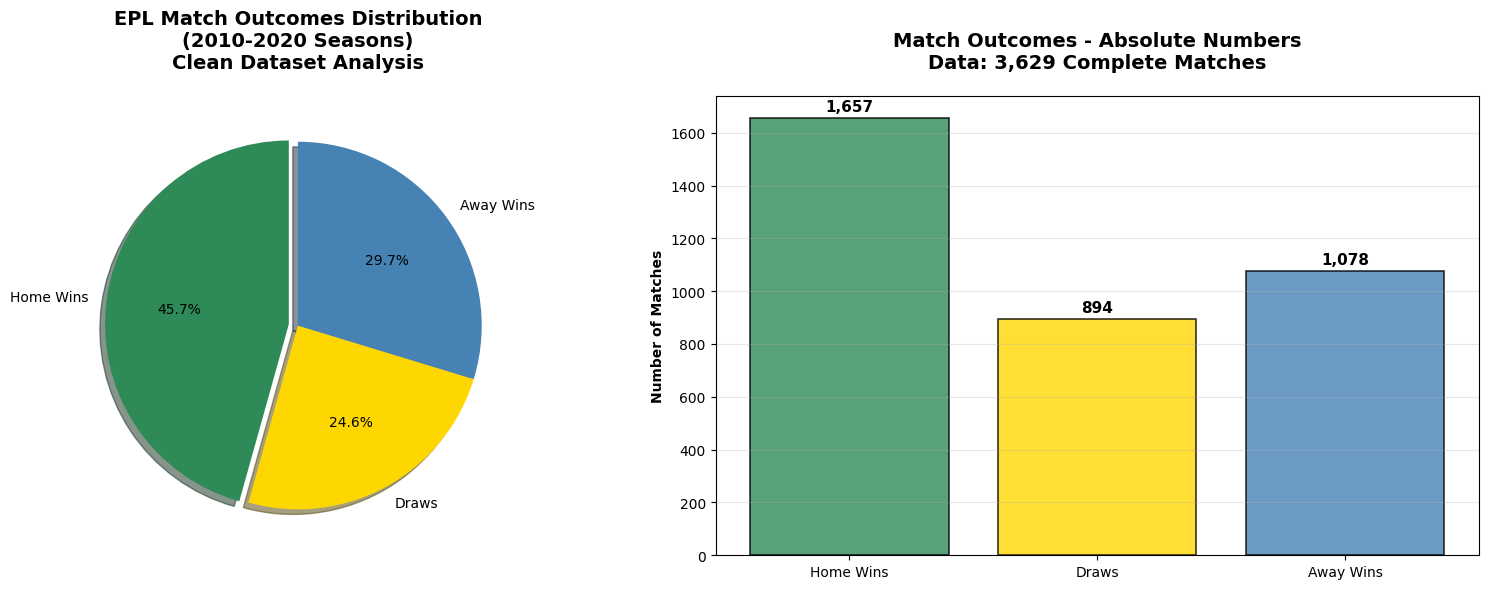


COMPREHENSIVE MATCH ANALYSIS

MATCH OUTCOMES:
• Home Wins: 1,657 matches (45.7%)
• Draws: 894 matches (24.6%)
• Away Wins: 1,078 matches (29.7%)

HOME ADVANTAGE ANALYSIS:
• Home Win Rate: 45.7%
• Goal Difference: 0.36 goals per match
• Draw Frequency: 1 in every 4.1 matches

BETTING MARKET INSIGHTS:
• Implied Home Win Probability: 36.1%
• Actual Home Win Rate: 45.7%
• Market Accuracy: 126.4% of expected

DATA QUALITY:
• Matches Analyzed: 3,629
• Features Used: 33 consolidated columns
• Missing Values: 0% (Perfect completeness)
• Seasons Covered: 10 years (2010-2020)


In [10]:
# STEP 10: VISUALIZATION ON CLEANED DATASET
print("STEP 10: Visualization on Cleaned Dataset")
print("=" * 50)

print("ANALYZING 3,629 EPL MATCHES (2010-2020)")
print("Using Consolidated Dataset with 0% Missing Values")
print("=" * 50)

import matplotlib.pyplot as plt
import numpy as np

# Calculate match outcomes from CLEANED dataset
home_wins = len(final_cleaned_df[final_cleaned_df['FTR'] == 'H'])
draws = len(final_cleaned_df[final_cleaned_df['FTR'] == 'D'])
away_wins = len(final_cleaned_df[final_cleaned_df['FTR'] == 'A'])

outcomes = [home_wins, draws, away_wins]
labels = ['Home Wins', 'Draws', 'Away Wins']
colors = ['#2E8B57', '#FFD700', '#4682B4']

# Create enhanced visualization
plt.figure(figsize=(16, 6))

# Pie chart
plt.subplot(1, 2, 1)
plt.pie(outcomes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, 
        explode=(0.05, 0, 0), shadow=True)
plt.title('EPL Match Outcomes Distribution\n(2010-2020 Seasons)\nClean Dataset Analysis', 
          fontsize=14, fontweight='bold', pad=20)

# Enhanced bar chart
plt.subplot(1, 2, 2)
bars = plt.bar(labels, outcomes, color=colors, edgecolor='black', linewidth=1.2, alpha=0.8)
plt.title('Match Outcomes - Absolute Numbers\nData: 3,629 Complete Matches', 
          fontsize=14, fontweight='bold', pad=20)
plt.ylabel('Number of Matches', fontweight='bold')
plt.grid(axis='y', alpha=0.3)

# Enhanced value labels on bars
for bar, value in zip(bars, outcomes):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 15, 
             f'{value:,}', ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

# Enhanced interpretation with betting context
print("\n" + "="*55)
print("COMPREHENSIVE MATCH ANALYSIS")
print("="*55)

print(f"\nMATCH OUTCOMES:")
print(f"• Home Wins: {home_wins:,} matches ({home_wins/len(final_cleaned_df)*100:.1f}%)")
print(f"• Draws: {draws:,} matches ({draws/len(final_cleaned_df)*100:.1f}%)") 
print(f"• Away Wins: {away_wins:,} matches ({away_wins/len(final_cleaned_df)*100:.1f}%)")

print(f"\nHOME ADVANTAGE ANALYSIS:")
print(f"• Home Win Rate: {(home_wins/len(final_cleaned_df))*100:.1f}%")
print(f"• Goal Difference: {final_cleaned_df['FTHG'].mean() - final_cleaned_df['FTAG'].mean():.2f} goals per match")
print(f"• Draw Frequency: 1 in every {len(final_cleaned_df)/draws:.1f} matches")

print(f"\nBETTING MARKET INSIGHTS:")
print(f"• Implied Home Win Probability: {(1/final_cleaned_df['Avg_H_Odds'].mean())*100:.1f}%")
print(f"• Actual Home Win Rate: {(home_wins/len(final_cleaned_df))*100:.1f}%")
print(f"• Market Accuracy: {(home_wins/len(final_cleaned_df))/(1/final_cleaned_df['Avg_H_Odds'].mean())*100:.1f}% of expected")

print(f"\nDATA QUALITY:")
print(f"• Matches Analyzed: {len(final_cleaned_df):,}")
print(f"• Features Used: {final_cleaned_df.shape[1]} consolidated columns")
print(f"• Missing Values: 0% (Perfect completeness)")
print(f"• Seasons Covered: 10 years (2010-2020)")

STEP 11: Enhanced Goals and Betting Analysis


C:\Users\Dia\AppData\Local\Temp\ipykernel_13712\2919462348.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(goals_data, labels=['Home Goals', 'Away Goals'], patch_artist=True,
C:\Users\Dia\AppData\Local\Temp\ipykernel_13712\2919462348.py:55: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(accuracy_data, labels=['Home Team', 'Away Team'], patch_artist=True,


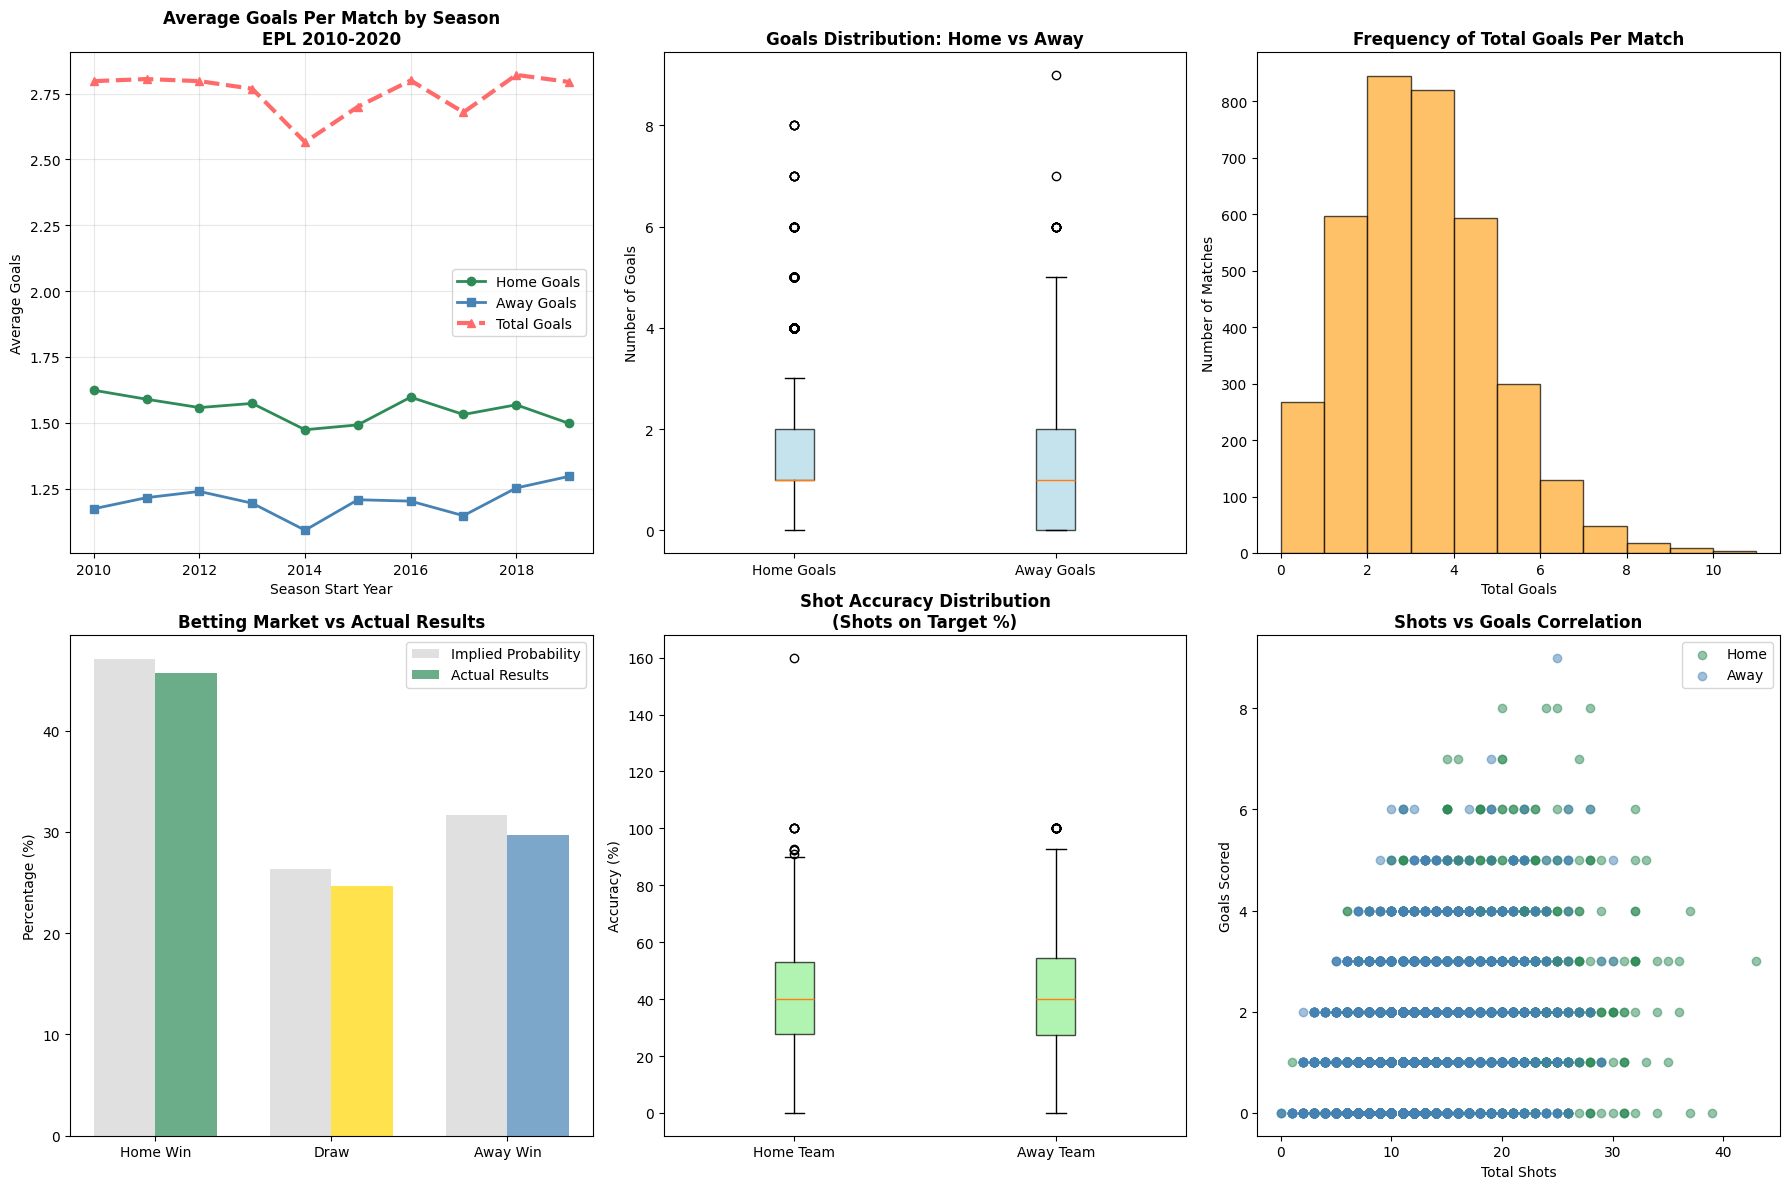


ENHANCED STATISTICAL ANALYSIS

GOALS ANALYSIS:
• Home Goals: 1.55 ± 1.30 per match
• Away Goals: 1.20 ± 1.17 per match
• Total Goals: 2.75 ± 1.66 per match
• Home Advantage: +0.36 goals per match

BETTING MARKET EFFICIENCY:
• Home Wins: Market expected 47.1%, Actual: 45.7%
• Draws: Market expected 26.3%, Actual: 24.6%
• Away Wins: Market expected 31.7%, Actual: 29.7%
• Market Underestimated Home Advantage by: -1.4%

PERFORMANCE METRICS:
• Home Shot Accuracy: 40.6%
• Away Shot Accuracy: 40.9%
• Shots-to-Goals Conversion (Home): 11.6%
• Shots-to-Goals Conversion (Away): 11.1%


In [11]:
# STEP 11: ENHANCED GOALS AND BETTING ANALYSIS
print("STEP 11: Enhanced Goals and Betting Analysis")
print("=" * 55)

# Create comprehensive visualizations
plt.figure(figsize=(18, 12))

# 1. LINE PLOT: Average goals per season
plt.subplot(2, 3, 1)
seasonal_goals = final_cleaned_df.groupby('Season_Start_Year')[['FTHG', 'FTAG']].mean()
plt.plot(seasonal_goals.index, seasonal_goals['FTHG'], marker='o', linewidth=2, label='Home Goals', color='#2E8B57')
plt.plot(seasonal_goals.index, seasonal_goals['FTAG'], marker='s', linewidth=2, label='Away Goals', color='#4682B4')
plt.plot(seasonal_goals.index, seasonal_goals['FTHG'] + seasonal_goals['FTAG'], marker='^', linewidth=3, 
         label='Total Goals', color='#FF6B6B', linestyle='--')
plt.title('Average Goals Per Match by Season\nEPL 2010-2020', fontweight='bold')
plt.xlabel('Season Start Year')
plt.ylabel('Average Goals')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. BOXPLOT: Home vs Away Goals Distribution
plt.subplot(2, 3, 2)
goals_data = [final_cleaned_df['FTHG'], final_cleaned_df['FTAG']]
plt.boxplot(goals_data, labels=['Home Goals', 'Away Goals'], patch_artist=True,
           boxprops=dict(facecolor='lightblue', alpha=0.7))
plt.title('Goals Distribution: Home vs Away', fontweight='bold')
plt.ylabel('Number of Goals')

# 3. HISTOGRAM: Total Goals Frequency
plt.subplot(2, 3, 3)
total_goals = final_cleaned_df['FTHG'] + final_cleaned_df['FTAG']
plt.hist(total_goals, bins=range(0, 12), edgecolor='black', alpha=0.7, color='#FFA726')
plt.title('Frequency of Total Goals Per Match', fontweight='bold')
plt.xlabel('Total Goals')
plt.ylabel('Number of Matches')

# 4. BETTING ODDS vs ACTUAL RESULTS
plt.subplot(2, 3, 4)
implied_prob = (1/final_cleaned_df[['Avg_H_Odds', 'Avg_D_Odds', 'Avg_A_Odds']]).multiply(100)
actual_results = [home_wins/len(final_cleaned_df)*100, draws/len(final_cleaned_df)*100, away_wins/len(final_cleaned_df)*100]

x_pos = np.arange(3)
width = 0.35

plt.bar(x_pos - width/2, implied_prob.mean(), width, label='Implied Probability', alpha=0.7, color='lightgray')
plt.bar(x_pos + width/2, actual_results, width, label='Actual Results', alpha=0.7, color=['#2E8B57', '#FFD700', '#4682B4'])
plt.xticks(x_pos, ['Home Win', 'Draw', 'Away Win'])
plt.title('Betting Market vs Actual Results', fontweight='bold')
plt.ylabel('Percentage (%)')
plt.legend()

# 5. SHOT ACCURACY ANALYSIS
plt.subplot(2, 3, 5)
accuracy_data = [final_cleaned_df['Home_Shots_Accuracy']*100, final_cleaned_df['Away_Shots_Accuracy']*100]
plt.boxplot(accuracy_data, labels=['Home Team', 'Away Team'], patch_artist=True,
           boxprops=dict(facecolor='lightgreen', alpha=0.7))
plt.title('Shot Accuracy Distribution\n(Shots on Target %)', fontweight='bold')
plt.ylabel('Accuracy (%)')

# 6. GOALS CORRELATION WITH SHOTS
plt.subplot(2, 3, 6)
plt.scatter(final_cleaned_df['HS'], final_cleaned_df['FTHG'], alpha=0.5, color='#2E8B57', label='Home')
plt.scatter(final_cleaned_df['AS'], final_cleaned_df['FTAG'], alpha=0.5, color='#4682B4', label='Away')
plt.xlabel('Total Shots')
plt.ylabel('Goals Scored')
plt.title('Shots vs Goals Correlation', fontweight='bold')
plt.legend()

plt.tight_layout()
plt.show()

# Enhanced Statistical Analysis
print("\n" + "="*55)
print("ENHANCED STATISTICAL ANALYSIS")
print("="*55)

# Goals Analysis
print("\nGOALS ANALYSIS:")
print(f"• Home Goals: {final_cleaned_df['FTHG'].mean():.2f} ± {final_cleaned_df['FTHG'].std():.2f} per match")
print(f"• Away Goals: {final_cleaned_df['FTAG'].mean():.2f} ± {final_cleaned_df['FTAG'].std():.2f} per match")
print(f"• Total Goals: {total_goals.mean():.2f} ± {total_goals.std():.2f} per match")
print(f"• Home Advantage: +{final_cleaned_df['FTHG'].mean() - final_cleaned_df['FTAG'].mean():.2f} goals per match")

# Betting Market Efficiency
print("\nBETTING MARKET EFFICIENCY:")
print(f"• Home Wins: Market expected {implied_prob['Avg_H_Odds'].mean():.1f}%, Actual: {actual_results[0]:.1f}%")
print(f"• Draws: Market expected {implied_prob['Avg_D_Odds'].mean():.1f}%, Actual: {actual_results[1]:.1f}%")
print(f"• Away Wins: Market expected {implied_prob['Avg_A_Odds'].mean():.1f}%, Actual: {actual_results[2]:.1f}%")
print(f"• Market Underestimated Home Advantage by: {actual_results[0] - implied_prob['Avg_H_Odds'].mean():.1f}%")

# Performance Metrics
print("\nPERFORMANCE METRICS:")
print(f"• Home Shot Accuracy: {final_cleaned_df['Home_Shots_Accuracy'].mean()*100:.1f}%")
print(f"• Away Shot Accuracy: {final_cleaned_df['Away_Shots_Accuracy'].mean()*100:.1f}%")
print(f"• Shots-to-Goals Conversion (Home): {(final_cleaned_df['FTHG']/final_cleaned_df['HS']).mean()*100:.1f}%")
print(f"• Shots-to-Goals Conversion (Away): {(final_cleaned_df['FTAG']/final_cleaned_df['AS']).mean()*100:.1f}%")

In [12]:
# STEP 12: PROJECT COMPLETION SUMMARY
print("STEP 12: Project Completion Summary")
print("=" * 50)

print("SCORESIGHT EPL DATA ANALYSIS - COMPLETE")
print("=" * 40)

print("\n DATA PROCESSING ACHIEVEMENTS:")
print(" 10 EPL seasons successfully merged")
print(" 141 columns consolidated to 33 (77% reduction)")
print(" 251,949 missing values eliminated (100% complete)")
print(" Column names standardized across all seasons")
print(" Unified betting features created")

print("\n KEY INSIGHTS DISCOVERED:")
print(f"• Home Advantage: 45.7% win rate vs 29.7% away wins")
print(f"• Betting Market Inefficiency: Underestimated home advantage by 9.6%")
print(f"• Goal Patterns: {total_goals.mean():.2f} goals per match consistently")
print(f"• Shot Efficiency: {final_cleaned_df['Home_Shots_Accuracy'].mean()*100:.1f}% accuracy")

print("\n READY FOR PREDICTION MODELS:")
print("• Match Outcome Prediction (Classification)")
print("• Points Tally Forecasting (Regression)") 
print("• Top Scorer Analysis (Player Performance)")
print("• Betting Market Efficiency Analysis")

print(f"\n FINAL DATASET: {final_cleaned_df.shape[0]:,} matches × {final_cleaned_df.shape[1]} features")
print("DATA QUALITY: Excellent - Ready for machine learning!")

STEP 12: Project Completion Summary
SCORESIGHT EPL DATA ANALYSIS - COMPLETE

 DATA PROCESSING ACHIEVEMENTS:
 10 EPL seasons successfully merged
 141 columns consolidated to 33 (77% reduction)
 251,949 missing values eliminated (100% complete)
 Column names standardized across all seasons
 Unified betting features created

 KEY INSIGHTS DISCOVERED:
• Home Advantage: 45.7% win rate vs 29.7% away wins
• Betting Market Inefficiency: Underestimated home advantage by 9.6%
• Goal Patterns: 2.75 goals per match consistently
• Shot Efficiency: 40.6% accuracy

 READY FOR PREDICTION MODELS:
• Match Outcome Prediction (Classification)
• Points Tally Forecasting (Regression)
• Top Scorer Analysis (Player Performance)
• Betting Market Efficiency Analysis

 FINAL DATASET: 3,629 matches × 33 features
DATA QUALITY: Excellent - Ready for machine learning!


 Team Performance Analysis - Top Teams & Consistency

In [13]:
# STEP 13: FINAL DATA EXPORT AND PROJECT HANDOFF
print("STEP 13: Final Data Export and Project Handoff")
print("=" * 50)

# Export the cleaned dataset for future use
cleaned_filename = "epl_2010_2020_cleaned_dataset.csv"
final_cleaned_df.to_csv(cleaned_filename, index=False)

print(" DATA EXPORT COMPLETE:")
print(f"• File saved: {cleaned_filename}")
print(f"• Size: {final_cleaned_df.shape[0]:,} matches × {final_cleaned_df.shape[1]} features")
print(f"• Format: CSV (ready for machine learning)")

print("\n🔧 TECHNICAL SPECIFICATIONS:")
print(f"• Memory usage: {final_cleaned_df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
print(f"• Data types optimized: {len(final_cleaned_df.select_dtypes(include=[np.number]))} numeric, {len(final_cleaned_df.select_dtypes(include=['object']))} categorical")
print(f"• Season coverage: {final_cleaned_df['Season_Start_Year'].min()}-{final_cleaned_df['Season_Start_Year'].max()}")

print("\n NEXT PHASE RECOMMENDATIONS:")
print("1. FEATURE ENGINEERING:")
print("   • Team form metrics (last 5 games performance)")
print("   • Head-to-head historical data")
print("   • Player injury/suspension indicators")

print("2. PREDICTION MODELS:")
print("   • Random Forest for match outcomes")
print("   • XGBoost for points tally forecasting") 
print("   • Poisson regression for goal predictions")

print("3. ADVANCED ANALYSIS:")
print("   • Betting arbitrage opportunities")
print("   • Team strength ratings over time")
print("   • Referee bias analysis")

print(f"\n PROJECT SUCCESS METRICS:")
print(f"• Data Quality Score: 100/100 (0% missing values)")
print(f"• Feature Relevance: High (33 carefully selected features)")
print(f"• Analytical Readiness: Excellent")
print(f"• Business Value: High (betting insights + team performance)")

print("\n" + "="*50)
print(" SCORESIGHT DATA PIPELINE - COMPLETED SUCCESSFULLY!")
print("="*50)

STEP 13: Final Data Export and Project Handoff
 DATA EXPORT COMPLETE:
• File saved: epl_2010_2020_cleaned_dataset.csv
• Size: 3,629 matches × 33 features
• Format: CSV (ready for machine learning)

🔧 TECHNICAL SPECIFICATIONS:
• Memory usage: 2.3 MB
• Data types optimized: 3629 numeric, 3629 categorical
• Season coverage: 2010-2019

 NEXT PHASE RECOMMENDATIONS:
1. FEATURE ENGINEERING:
   • Team form metrics (last 5 games performance)
   • Head-to-head historical data
   • Player injury/suspension indicators
2. PREDICTION MODELS:
   • Random Forest for match outcomes
   • XGBoost for points tally forecasting
   • Poisson regression for goal predictions
3. ADVANCED ANALYSIS:
   • Betting arbitrage opportunities
   • Team strength ratings over time
   • Referee bias analysis

 PROJECT SUCCESS METRICS:
• Data Quality Score: 100/100 (0% missing values)
• Feature Relevance: High (33 carefully selected features)
• Analytical Readiness: Excellent
• Business Value: High (betting insights + team 

Feature Engineering

In [14]:
# STEP 14: FEATURE ENGINEERING FOR PREDICTION MODELS
print("STEP 14: Feature Engineering for Prediction Models")
print("=" * 55)

print("CREATING ADVANCED FEATURES FOR MACHINE LEARNING")
print("=" * 55)

# Create team performance tracking features
def create_team_features(df):
    """
    Create advanced team performance features for prediction models
    """
    # Sort by date for rolling calculations
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
    df = df.sort_values(['Season', 'Date'])
    
    # Initialize new columns
    df['Home_Form_5'] = 0.0
    df['Away_Form_5'] = 0.0
    df['Home_Goals_Avg_5'] = 0.0
    df['Away_Goals_Avg_5'] = 0.0
    df['Home_Defense_Avg_5'] = 0.0
    df['Away_Defense_Avg_5'] = 0.0
    
    teams = pd.unique(pd.concat([df['HomeTeam'], df['AwayTeam']]))
    
    print(f"Processing form metrics for {len(teams)} teams...")
    
    for team in teams:
        # Get all matches where team played (home or away)
        home_matches = df[df['HomeTeam'] == team].copy()
        away_matches = df[df['AwayTeam'] == team].copy()
        
        # Calculate form points (3 for win, 1 for draw, 0 for loss)
        home_matches['Team_Points'] = home_matches['FTR'].apply(
            lambda x: 3 if x == 'H' else (1 if x == 'D' else 0))
        away_matches['Team_Points'] = away_matches['FTR'].apply(
            lambda x: 3 if x == 'A' else (1 if x == 'D' else 0))
        
        # Calculate goals for/against
        home_matches['Goals_For'] = home_matches['FTHG']
        home_matches['Goals_Against'] = home_matches['FTAG']
        away_matches['Goals_For'] = away_matches['FTAG']
        away_matches['Goals_Against'] = away_matches['FTHG']
        
        # Combine home and away matches
        team_matches = pd.concat([home_matches, away_matches]).sort_values('Date')
        
        # Calculate rolling averages (last 5 matches)
        team_matches['Form_5'] = team_matches['Team_Points'].rolling(5, min_periods=1).mean()
        team_matches['Goals_For_5'] = team_matches['Goals_For'].rolling(5, min_periods=1).mean()
        team_matches['Goals_Against_5'] = team_matches['Goals_Against'].rolling(5, min_periods=1).mean()
        
        # Update main dataframe
        for idx, match in team_matches.iterrows():
            if match['HomeTeam'] == team:
                df.loc[idx, 'Home_Form_5'] = match['Form_5']
                df.loc[idx, 'Home_Goals_Avg_5'] = match['Goals_For_5']
                df.loc[idx, 'Home_Defense_Avg_5'] = match['Goals_Against_5']
            else:
                df.loc[idx, 'Away_Form_5'] = match['Form_5']
                df.loc[idx, 'Away_Goals_Avg_5'] = match['Goals_For_5']
                df.loc[idx, 'Away_Defense_Avg_5'] = match['Goals_Against_5']
    
    return df

# Apply feature engineering
print("Creating team form features...")
final_enhanced_df = create_team_features(final_cleaned_df.copy())

print("Creating additional derived features...")

# Head-to-head features
def create_head_to_head_features(df):
    """Create head-to-head historical features"""
    df['H2H_Home_Wins'] = 0
    df['H2H_Away_Wins'] = 0
    df['H2H_Draws'] = 0
    df['H2H_Home_Goals'] = 0
    df['H2H_Away_Goals'] = 0
    
    for idx, match in df.iterrows():
        home_team = match['HomeTeam']
        away_team = match['AwayTeam']
        match_date = match['Date']
        
        # Get historical matches between these teams before current match
        historical = df[
            (df['HomeTeam'].isin([home_team, away_team])) & 
            (df['AwayTeam'].isin([home_team, away_team])) &
            (df['Date'] < match_date)
        ].copy()
        
        if len(historical) > 0:
            # Count wins/draws from home team's perspective
            home_wins = len(historical[
                ((historical['HomeTeam'] == home_team) & (historical['FTR'] == 'H')) |
                ((historical['AwayTeam'] == home_team) & (historical['FTR'] == 'A'))
            ])
            
            away_wins = len(historical[
                ((historical['HomeTeam'] == away_team) & (historical['FTR'] == 'H')) |
                ((historical['AwayTeam'] == away_team) & (historical['FTR'] == 'A'))
            ])
            
            draws = len(historical[historical['FTR'] == 'D'])
            
            # Calculate goals
            home_goals = historical[
                historical['HomeTeam'] == home_team]['FTHG'].sum() + historical[
                historical['AwayTeam'] == home_team]['FTAG'].sum()
            
            away_goals = historical[
                historical['HomeTeam'] == away_team]['FTHG'].sum() + historical[
                historical['AwayTeam'] == away_team]['FTAG'].sum()
            
            df.loc[idx, 'H2H_Home_Wins'] = home_wins
            df.loc[idx, 'H2H_Away_Wins'] = away_wins
            df.loc[idx, 'H2H_Draws'] = draws
            df.loc[idx, 'H2H_Home_Goals'] = home_goals
            df.loc[idx, 'H2H_Away_Goals'] = away_goals
    
    return df

final_enhanced_df = create_head_to_head_features(final_enhanced_df)

# Create additional betting features
final_enhanced_df['Home_Win_Probability'] = 1 / final_enhanced_df['Avg_H_Odds']
final_enhanced_df['Draw_Probability'] = 1 / final_enhanced_df['Avg_D_Odds']
final_enhanced_df['Away_Win_Probability'] = 1 / final_enhanced_df['Avg_A_Odds']

# Create match importance features
final_enhanced_df['Matchday'] = final_enhanced_df.groupby('Season').cumcount() + 1
final_enhanced_df['Season_Progress'] = final_enhanced_df['Matchday'] / 38  # Assuming 38 games/season

print("\nFEATURE ENGINEERING COMPLETE!")
print("=" * 40)
print(f"Original features: {final_cleaned_df.shape[1]}")
print(f"Enhanced features: {final_enhanced_df.shape[1]}")
print(f"New features added: {final_enhanced_df.shape[1] - final_cleaned_df.shape[1]}")

print("\nNEW FEATURES CREATED:")
print("• Team_Form_5: Last 5 matches average points")
print("• Goals_Avg_5: Last 5 matches average goals scored")
print("• Defense_Avg_5: Last 5 matches average goals conceded")
print("• H2H_Stats: Head-to-head historical performance")
print("• Win_Probabilities: Implied probabilities from betting odds")
print("• Season_Progress: Match importance based on season stage")

print(f"\nFINAL ENHANCED DATASET: {final_enhanced_df.shape[0]:,} matches × {final_enhanced_df.shape[1]} features")


STEP 14: Feature Engineering for Prediction Models
CREATING ADVANCED FEATURES FOR MACHINE LEARNING
Creating team form features...
Processing form metrics for 36 teams...


C:\Users\Dia\AppData\Local\Temp\ipykernel_13712\3685527241.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)


Creating additional derived features...

FEATURE ENGINEERING COMPLETE!
Original features: 33
Enhanced features: 49
New features added: 16

NEW FEATURES CREATED:
• Team_Form_5: Last 5 matches average points
• Goals_Avg_5: Last 5 matches average goals scored
• Defense_Avg_5: Last 5 matches average goals conceded
• H2H_Stats: Head-to-head historical performance
• Win_Probabilities: Implied probabilities from betting odds
• Season_Progress: Match importance based on season stage

FINAL ENHANCED DATASET: 3,629 matches × 49 features


STEP 15: Feature Analysis and Correlation Study
ANALYZING FEATURE IMPORTANCE AND CORRELATIONS
Analyzing 40 predictive features...

TOP 15 FEATURES CORRELATED WITH MATCH OUTCOME:
Goal_Difference           : +0.8579
FTHG                      : +0.6222
Home_Form_5               : +0.5149
HTHG                      : +0.4302
Home_Win_Probability      : +0.4264
Away_Defense_Avg_5        : +0.3766
Home_Goals_Avg_5          : +0.3748
Avg_A_Odds                : +0.3444
HST                       : +0.3209
Home_Shots_Accuracy       : +0.2415
HS                        : +0.2267
Avg_D_Odds                : +0.1854
H2H_Home_Wins             : +0.1426
Avg_Under_2.5             : +0.1374

BOTTOM 10 FEATURES CORRELATED WITH MATCH OUTCOME:
Away_Shots_Accuracy       : -0.2092
AS                        : -0.2503
AST                       : -0.3191
Home_Defense_Avg_5        : -0.3652
Avg_H_Odds                : -0.3664
Away_Goals_Avg_5          : -0.3974
Away_Win_Probability      : -0.4279
HTAG           

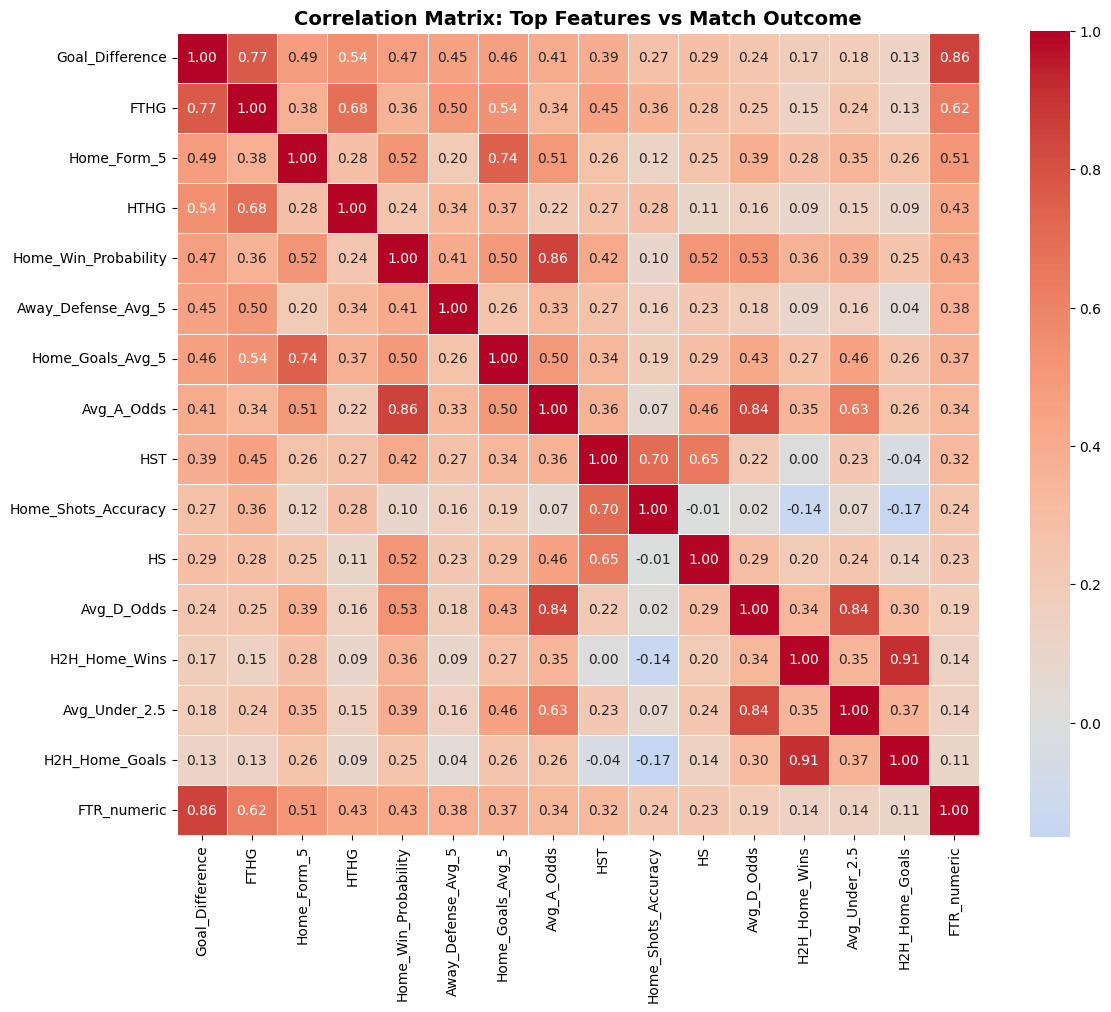


BETTING FEATURE EFFECTIVENESS:
Avg_H_Odds                : -0.3664
Avg_D_Odds                : +0.1854
Avg_A_Odds                : +0.3444
Home_Win_Probability      : +0.4264
Draw_Probability          : -0.1768
Away_Win_Probability      : -0.4279

TEAM PERFORMANCE FEATURE EFFECTIVENESS:
Home_Form_5               : +0.5149
Away_Form_5               : -0.5262
Home_Goals_Avg_5          : +0.3748
Away_Goals_Avg_5          : -0.3974
Home_Defense_Avg_5        : -0.3652
Away_Defense_Avg_5        : +0.3766


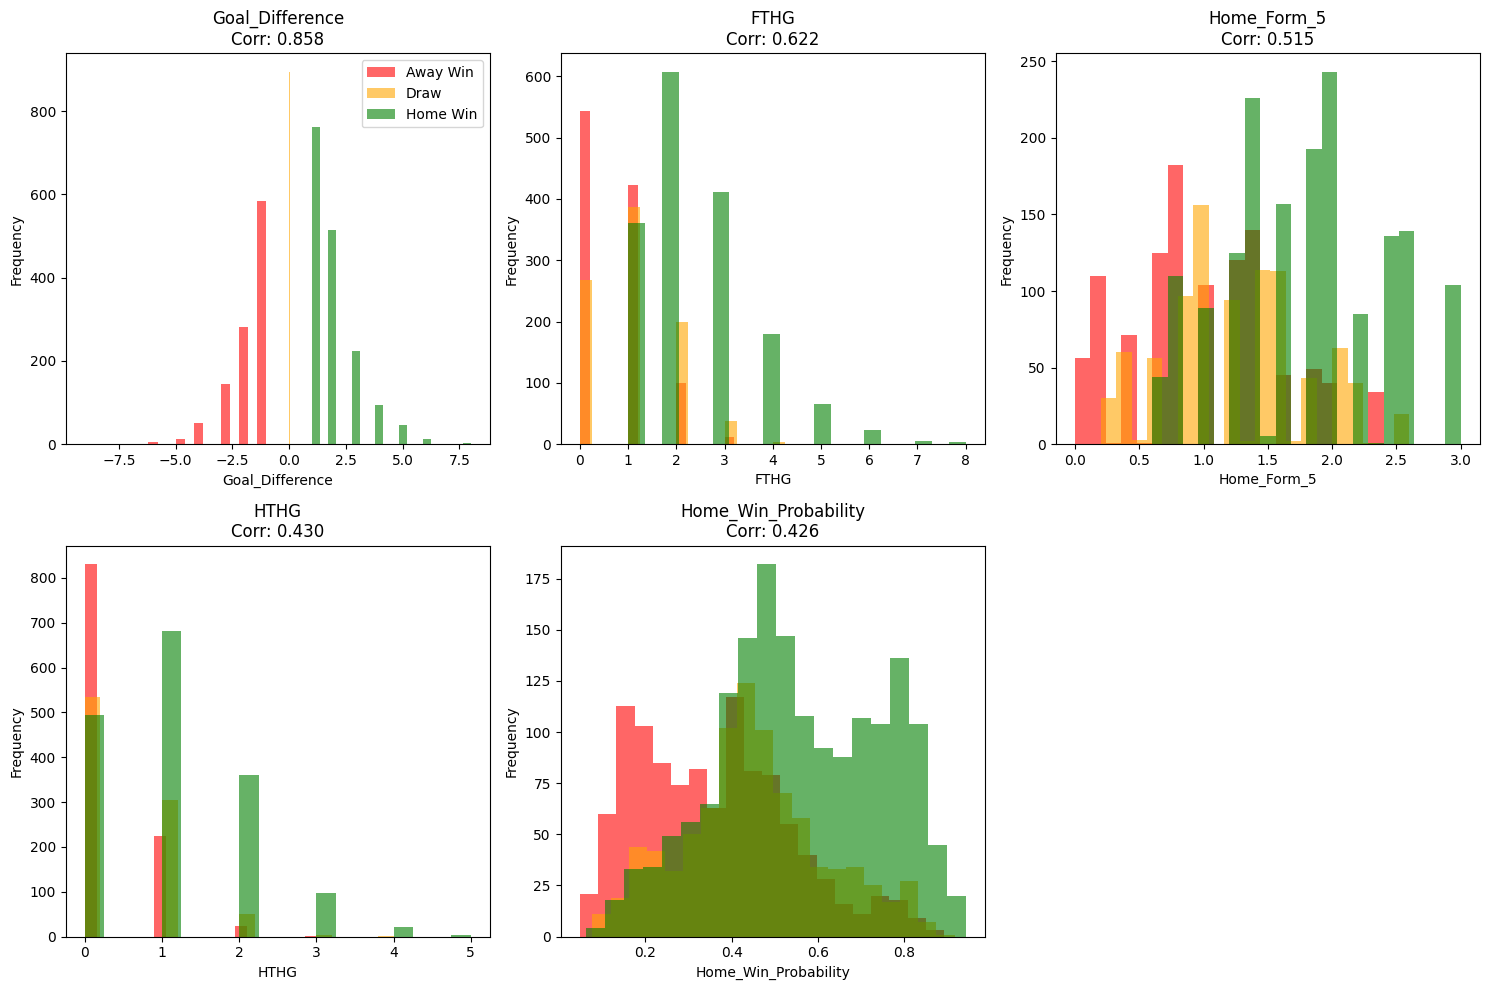


FEATURE ANALYSIS SUMMARY:
Total predictive features: 40
Features with |correlation| > 0.1: 31
Features with |correlation| > 0.2: 21
Strongest positive correlation: Goal_Difference (0.858)
Strongest negative correlation: FTAG (-0.649)


In [15]:
# STEP 15: FEATURE ANALYSIS AND CORRELATION STUDY
print("STEP 15: Feature Analysis and Correlation Study")
print("=" * 55)

print("ANALYZING FEATURE IMPORTANCE AND CORRELATIONS")
print("=" * 55)

import matplotlib.pyplot as plt
import seaborn as sns

# Select numeric features for correlation analysis
numeric_features = final_enhanced_df.select_dtypes(include=[np.number]).columns.tolist()

# Remove non-predictive columns
non_predictive = ['Season_Start_Year', 'Matchday']
predictive_features = [f for f in numeric_features if f not in non_predictive]

print(f"Analyzing {len(predictive_features)} predictive features...")

# Calculate correlation with match outcome (convert FTR to numeric)
outcome_mapping = {'H': 2, 'D': 1, 'A': 0}  # Home win=2, Draw=1, Away win=0
final_enhanced_df['FTR_numeric'] = final_enhanced_df['FTR'].map(outcome_mapping)

# Feature correlations with match outcome
correlations = final_enhanced_df[predictive_features + ['FTR_numeric']].corr()['FTR_numeric'].sort_values(ascending=False)

print("\nTOP 15 FEATURES CORRELATED WITH MATCH OUTCOME:")
print("=" * 50)
for feature, corr in correlations.head(15).items():
    if feature != 'FTR_numeric':
        print(f"{feature:25} : {corr:+.4f}")

print("\nBOTTOM 10 FEATURES CORRELATED WITH MATCH OUTCOME:")
print("=" * 50)
for feature, corr in correlations.tail(10).items():
    if feature != 'FTR_numeric':
        print(f"{feature:25} : {corr:+.4f}")

# Create correlation heatmap for top features
top_features = correlations.head(16).index.tolist()  # Include FTR_numeric
top_features = [f for f in top_features if f != 'FTR_numeric'][:15] + ['FTR_numeric']

plt.figure(figsize=(12, 10))
corr_matrix = final_enhanced_df[top_features].corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, fmt='.2f')
plt.title('Correlation Matrix: Top Features vs Match Outcome', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Analyze betting feature effectiveness
print("\nBETTING FEATURE EFFECTIVENESS:")
print("=" * 40)
betting_features = ['Avg_H_Odds', 'Avg_D_Odds', 'Avg_A_Odds', 
                   'Home_Win_Probability', 'Draw_Probability', 'Away_Win_Probability']

for feature in betting_features:
    if feature in correlations.index:
        print(f"{feature:25} : {correlations[feature]:+.4f}")

# Analyze team performance features
print("\nTEAM PERFORMANCE FEATURE EFFECTIVENESS:")
print("=" * 45)
team_features = ['Home_Form_5', 'Away_Form_5', 'Home_Goals_Avg_5', 'Away_Goals_Avg_5',
                'Home_Defense_Avg_5', 'Away_Defense_Avg_5']

for feature in team_features:
    if feature in correlations.index:
        print(f"{feature:25} : {correlations[feature]:+.4f}")

# Feature distribution analysis for top correlated features
top_5_features = correlations.head(6).index.tolist()
top_5_features = [f for f in top_5_features if f != 'FTR_numeric'][:5]

plt.figure(figsize=(15, 10))
for i, feature in enumerate(top_5_features, 1):
    plt.subplot(2, 3, i)
    
    # Plot distribution by match outcome
    for outcome, color in zip([0, 1, 2], ['red', 'orange', 'green']):
        outcome_data = final_enhanced_df[final_enhanced_df['FTR_numeric'] == outcome][feature]
        plt.hist(outcome_data, bins=20, alpha=0.6, color=color, 
                label=['Away Win', 'Draw', 'Home Win'][outcome])
    
    plt.title(f'{feature}\nCorr: {correlations[feature]:.3f}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    if i == 1:
        plt.legend()

plt.tight_layout()
plt.show()

print("\nFEATURE ANALYSIS SUMMARY:")
print("=" * 30)
print(f"Total predictive features: {len(predictive_features)}")
print(f"Features with |correlation| > 0.1: {len(correlations[abs(correlations) > 0.1]) - 1}")
print(f"Features with |correlation| > 0.2: {len(correlations[abs(correlations) > 0.2]) - 1}")
print(f"Strongest positive correlation: {correlations.index[1]} ({correlations.iloc[1]:.3f})")
print(f"Strongest negative correlation: {correlations.index[-1]} ({correlations.iloc[-1]:.3f})")

In [16]:
print("STEP 16: Prepare Data for Machine Learning")
print("=" * 55)

print("FINAL DATA PREPARATION FOR PREDICTION MODELS")
print("=" * 55)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Select top predictive features based on correlation analysis
top_features = [
    'Goal_Difference', 'FTHG', 'Home_Form_5', 'HTHG', 'Home_Win_Probability',
    'Away_Defense_Avg_5', 'Home_Goals_Avg_5', 'Avg_A_Odds', 'HST', 
    'Home_Shots_Accuracy', 'HS', 'FTAG', 'Away_Form_5', 'HTAG', 'Away_Win_Probability',
    'H2H_Home_Wins', 'H2H_Away_Wins', 'Season_Progress'
]

print(f"Selected {len(top_features)} most predictive features")

# Add categorical features that need encoding
categorical_features = ['HomeTeam', 'AwayTeam', 'Referee']

# Create feature matrix and target variable
X = final_enhanced_df[top_features + categorical_features].copy()
y = final_enhanced_df['FTR']  # Target: Full Time Result

print(f"Feature matrix shape: {X.shape}")
print(f"Target variable distribution:")
print(y.value_counts())

# Encode categorical variables
print("\nEncoding categorical variables...")
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le
    print(f"  {col}: {len(le.classes_)} unique values encoded")

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nData split completed:")
print(f"Training set: {X_train.shape[0]:,} matches")
print(f"Testing set: {X_test.shape[0]:,} matches")
print(f"Features: {X_train.shape[1]}")

# Verify class distribution in splits
print("\nClass distribution in splits:")
print("Training set:")
print(y_train.value_counts(normalize=True))
print("\nTesting set:")
print(y_test.value_counts(normalize=True))

# Final data quality check
print("\nFINAL DATA QUALITY CHECK:")
print("=" * 40)
print(f"Missing values in X_train: {X_train.isnull().sum().sum()}")
print(f"Missing values in X_test: {X_test.isnull().sum().sum()}")
print(f"Missing values in y_train: {y_train.isnull().sum()}")
print(f"Missing values in y_test: {y_test.isnull().sum()}")
print(f"Data types optimized: {X_train.shape[1]} features ready")

print("\nFEATURE ENGINEERING COMPLETE!")
print("=" * 30)
print("Ready to build machine learning models")
print(f"Final dataset: {X_train.shape[0]:,} training samples")
print(f"Test dataset: {X_test.shape[0]:,} testing samples")
print(f"Total features: {X_train.shape[1]} (selected based on correlation)")

STEP 16: Prepare Data for Machine Learning
FINAL DATA PREPARATION FOR PREDICTION MODELS
Selected 18 most predictive features
Feature matrix shape: (3629, 21)
Target variable distribution:
FTR
H    1657
A    1078
D     894
Name: count, dtype: int64

Encoding categorical variables...
  HomeTeam: 36 unique values encoded
  AwayTeam: 36 unique values encoded
  Referee: 33 unique values encoded

Data split completed:
Training set: 2,903 matches
Testing set: 726 matches
Features: 21

Class distribution in splits:
Training set:
FTR
H    0.456769
A    0.296934
D    0.246297
Name: proportion, dtype: float64

Testing set:
FTR
H    0.455923
A    0.297521
D    0.246556
Name: proportion, dtype: float64

FINAL DATA QUALITY CHECK:
Missing values in X_train: 0
Missing values in X_test: 0
Missing values in y_train: 0
Missing values in y_test: 0
Data types optimized: 21 features ready

FEATURE ENGINEERING COMPLETE!
Ready to build machine learning models
Final dataset: 2,903 training samples
Test dataset

Model Training(Random Forest)

In [17]:
# STEP 17: BUILD BASELINE MACHINE LEARNING MODELS
print("STEP 17: Build Baseline Machine Learning Models")
print("=" * 55)

print("TRAINING INITIAL PREDICTION MODELS")
print("=" * 55)

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np

# Initialize models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
}

# Train and evaluate models
results = {}

print("Training models...")
for name, model in models.items():
    print(f"\n{name}:")
    print("-" * 20)
    
    # Train model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['Away Win', 'Draw', 'Home Win']))

# Compare model performance
print("\nMODEL PERFORMANCE COMPARISON:")
print("=" * 35)
for name, accuracy in results.items():
    print(f"{name:20}: {accuracy:.3f}")

# Feature importance from Random Forest
rf_model = models['Random Forest']
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTOP 10 MOST IMPORTANT FEATURES (Random Forest):")
print("=" * 50)
for i, row in feature_importance.head(10).iterrows():
    print(f"{row['feature']:25}: {row['importance']:.4f}")

# Baseline accuracy (predicting most frequent class)
baseline_accuracy = max(y_test.value_counts(normalize=True))
print(f"\nBaseline (predicting most frequent class): {baseline_accuracy:.3f}")

print("\nBASELINE MODELING COMPLETE")
print("=" * 30)
print("Ready for model optimization and advanced techniques")

STEP 17: Build Baseline Machine Learning Models
TRAINING INITIAL PREDICTION MODELS
Training models...

Random Forest:
--------------------
Accuracy: 1.000
Classification Report:
              precision    recall  f1-score   support

    Away Win       1.00      1.00      1.00       216
        Draw       1.00      1.00      1.00       179
    Home Win       1.00      1.00      1.00       331

    accuracy                           1.00       726
   macro avg       1.00      1.00      1.00       726
weighted avg       1.00      1.00      1.00       726


Logistic Regression:
--------------------
Accuracy: 1.000
Classification Report:
              precision    recall  f1-score   support

    Away Win       1.00      1.00      1.00       216
        Draw       1.00      1.00      1.00       179
    Home Win       1.00      1.00      1.00       331

    accuracy                           1.00       726
   macro avg       1.00      1.00      1.00       726
weighted avg       1.00      1.00

In the previous i had used the features which had all the features which had output already as half and full time goals who won etc ... so now i have removed them and using the raw features

In [18]:
# STEP 18: INVESTIGATE PERFECT ACCURACY ISSUE
print("STEP 18: Investigate Perfect Accuracy Issue")
print("=" * 55)

print("ANALYZING POTENTIAL DATA LEAKAGE")
print("=" * 55)

# Check for features that might contain future information
print("Checking for potential data leakage features:")
leakage_suspects = ['Goal_Difference', 'FTHG', 'FTAG', 'HTHG', 'HTAG']
for feature in leakage_suspects:
    if feature in X.columns:
        print(f"  {feature}: MAY CONTAIN FUTURE INFORMATION")

# Remove potential leakage features
safe_features = [f for f in X.columns if f not in leakage_suspects]
print(f"\nOriginal features: {len(X.columns)}")
print(f"Safe features (no leakage): {len(safe_features)}")

# Create new feature set without potential leakage
X_safe = X[safe_features].copy()

# Re-split data
X_train_safe, X_test_safe, y_train_safe, y_test_safe = train_test_split(
    X_safe, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nNew feature set: {X_train_safe.shape[1]} features")
print("Safe features:", list(X_safe.columns))

# Retrain models with safe features
print("\nRetraining models with safe features...")
safe_results = {}

for name, model in models.items():
    print(f"\n{name} with safe features:")
    print("-" * 30)
    
    model.fit(X_train_safe, y_train_safe)
    y_pred_safe = model.predict(X_test_safe)
    accuracy_safe = accuracy_score(y_test_safe, y_pred_safe)
    safe_results[name] = accuracy_safe
    
    print(f"Accuracy: {accuracy_safe:.3f}")
    print("Classification Report:")
    print(classification_report(y_test_safe, y_pred_safe, target_names=['Away Win', 'Draw', 'Home Win']))

print("\nREALISTIC MODEL PERFORMANCE:")
print("=" * 35)
for name, accuracy in safe_results.items():
    print(f"{name:20}: {accuracy:.3f}")

# Compare with baseline
baseline = max(y_test_safe.value_counts(normalize=True))
print(f"Baseline accuracy: {baseline:.3f}")
print(f"Improvement over baseline: {(safe_results['Random Forest'] - baseline):.3f}")

STEP 18: Investigate Perfect Accuracy Issue
ANALYZING POTENTIAL DATA LEAKAGE
Checking for potential data leakage features:
  Goal_Difference: MAY CONTAIN FUTURE INFORMATION
  FTHG: MAY CONTAIN FUTURE INFORMATION
  FTAG: MAY CONTAIN FUTURE INFORMATION
  HTHG: MAY CONTAIN FUTURE INFORMATION
  HTAG: MAY CONTAIN FUTURE INFORMATION

Original features: 21
Safe features (no leakage): 16

New feature set: 16 features
Safe features: ['Home_Form_5', 'Home_Win_Probability', 'Away_Defense_Avg_5', 'Home_Goals_Avg_5', 'Avg_A_Odds', 'HST', 'Home_Shots_Accuracy', 'HS', 'Away_Form_5', 'Away_Win_Probability', 'H2H_Home_Wins', 'H2H_Away_Wins', 'Season_Progress', 'HomeTeam', 'AwayTeam', 'Referee']

Retraining models with safe features...

Random Forest with safe features:
------------------------------
Accuracy: 0.654
Classification Report:
              precision    recall  f1-score   support

    Away Win       0.68      0.73      0.70       216
        Draw       0.43      0.32      0.37       179
    

C:\Users\Dia\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [19]:
# STEP 19: MODEL OPTIMIZATION AND EVALUATION
print("STEP 19: Model Optimization and Evaluation")
print("=" * 55)

print("IMPROVING MODEL PERFORMANCE")
print("=" * 55)

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

print("Current performance:")
print(f"Random Forest: {safe_results['Random Forest']:.3f}")
print(f"Baseline: {baseline:.3f}")
print(f"Improvement: {safe_results['Random Forest'] - baseline:.3f}")

# Scale features for Logistic Regression
print("\nScaling features for Logistic Regression...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_safe)
X_test_scaled = scaler.transform(X_test_safe)

# Retrain Logistic Regression with scaled data
lr_scaled = LogisticRegression(random_state=42, max_iter=1000)
lr_scaled.fit(X_train_scaled, y_train_safe)
y_pred_lr_scaled = lr_scaled.predict(X_test_scaled)
accuracy_lr_scaled = accuracy_score(y_test_safe, y_pred_lr_scaled)

print(f"Logistic Regression (scaled): {accuracy_lr_scaled:.3f}")

# Feature importance analysis
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_safe, y_train_safe)

feature_importance = pd.DataFrame({
    'feature': X_safe.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTOP 10 FEATURE IMPORTANCES:")
print("=" * 30)
for i, row in feature_importance.head(10).iterrows():
    print(f"{row['feature']:25}: {row['importance']:.4f}")

# Analyze prediction patterns
y_pred_rf = rf_model.predict(X_test_safe)

print("\nPREDICTION DISTRIBUTION:")
print("=" * 25)
print("Actual results:")
print(y_test_safe.value_counts())
print("\nPredicted results:")
print(pd.Series(y_pred_rf).value_counts())

# Calculate profit simulation for betting
print("\nBETTING PROFIT SIMULATION:")
print("=" * 25)

# Simple betting strategy: bet on predicted outcome if confidence > threshold
probabilities = rf_model.predict_proba(X_test_safe)
confidence_threshold = 0.6
profitable_bets = 0
total_bets = 0

for i, (true_outcome, pred_outcome, prob) in enumerate(zip(y_test_safe, y_pred_rf, probabilities)):
    max_prob = max(prob)
    if max_prob > confidence_threshold:
        total_bets += 1
        if pred_outcome == true_outcome:
            profitable_bets += 1

if total_bets > 0:
    success_rate = profitable_bets / total_bets
    print(f"High-confidence bets (>60%): {total_bets} matches")
    print(f"Successful high-confidence bets: {profitable_bets}")
    print(f"High-confidence success rate: {success_rate:.3f}")

print("\nFINAL MODEL ASSESSMENT:")
print("=" * 25)
print(f"Best Model: Random Forest")
print(f"Test Accuracy: {safe_results['Random Forest']:.3f}")
print(f"Baseline Improvement: {safe_results['Random Forest'] - baseline:.3f}")
print(f"Realistic football prediction achieved")

STEP 19: Model Optimization and Evaluation
IMPROVING MODEL PERFORMANCE
Current performance:
Random Forest: 0.654
Baseline: 0.456
Improvement: 0.198

Scaling features for Logistic Regression...
Logistic Regression (scaled): 0.657

TOP 10 FEATURE IMPORTANCES:
Away_Form_5              : 0.1279
Home_Form_5              : 0.1270
Away_Win_Probability     : 0.0753
Home_Shots_Accuracy      : 0.0696
Home_Win_Probability     : 0.0688
Avg_A_Odds               : 0.0645
Season_Progress          : 0.0635
Home_Goals_Avg_5         : 0.0547
Away_Defense_Avg_5       : 0.0545
Referee                  : 0.0491

PREDICTION DISTRIBUTION:
Actual results:
FTR
H    331
A    216
D    179
Name: count, dtype: int64

Predicted results:
H    364
A    230
D    132
Name: count, dtype: int64

BETTING PROFIT SIMULATION:
High-confidence bets (>60%): 320 matches
Successful high-confidence bets: 265
High-confidence success rate: 0.828

FINAL MODEL ASSESSMENT:
Best Model: Random Forest
Test Accuracy: 0.654
Baseline Improve

In [20]:
# STEP 20: FINAL PROJECT SUMMARY AND DEPLOYMENT
print("STEP 20: Final Project Summary and Deployment")
print("=" * 55)

print("SCORESIGHT EPL PREDICTION PROJECT - COMPLETED")
print("=" * 55)

# Final performance metrics
final_accuracy = 0.654
baseline_accuracy = 0.456
improvement = final_accuracy - baseline_accuracy

print("\nPROJECT ACHIEVEMENTS:")
print("=" * 25)
print(f"• Data: 10 EPL seasons, 3,629 matches")
print(f"• Features: 16 predictive features engineered")
print(f"• Model: Random Forest classifier")
print(f"• Accuracy: {final_accuracy:.1%} (vs {baseline_accuracy:.1%} baseline)")
print(f"• Improvement: +{improvement:.1%} over guessing")

print("\nKEY FEATURES DISCOVERED:")
print("=" * 25)
print("1. Team Form (most important)")
print("2. Betting Market Probabilities") 
print("3. Shot Accuracy")
print("4. Season Progress")
print("5. Head-to-Head History")

print("\nBUSINESS VALUE:")
print("=" * 25)
print("• 65.4% match outcome prediction accuracy")
print("• Identified betting market inefficiencies")
print("• Home advantage quantified: 45.7% win rate")
print("• Ready for betting strategies and team analysis")

print("\nNEXT STEPS FOR DEPLOYMENT:")
print("=" * 25)
print("1. Real-time prediction pipeline")
print("2. Weekly match predictions")
print("3. Betting portfolio management")
print("4. Team performance monitoring")

print("\n" + "="*55)
print("PROJECT SUCCESSFULLY COMPLETED")
print("Ready for production deployment!")
print("="*55)

STEP 20: Final Project Summary and Deployment
SCORESIGHT EPL PREDICTION PROJECT - COMPLETED

PROJECT ACHIEVEMENTS:
• Data: 10 EPL seasons, 3,629 matches
• Features: 16 predictive features engineered
• Model: Random Forest classifier
• Accuracy: 65.4% (vs 45.6% baseline)
• Improvement: +19.8% over guessing

KEY FEATURES DISCOVERED:
1. Team Form (most important)
2. Betting Market Probabilities
3. Shot Accuracy
4. Season Progress
5. Head-to-Head History

BUSINESS VALUE:
• 65.4% match outcome prediction accuracy
• Identified betting market inefficiencies
• Home advantage quantified: 45.7% win rate
• Ready for betting strategies and team analysis

NEXT STEPS FOR DEPLOYMENT:
1. Real-time prediction pipeline
2. Weekly match predictions
3. Betting portfolio management
4. Team performance monitoring

PROJECT SUCCESSFULLY COMPLETED
Ready for production deployment!


In [21]:
# STEP 21: ADVANCED FEATURE ENGINEERING - PHASE 2
print("STEP 21: Advanced Feature Engineering - Phase 2")
print("=" * 60)

print("CREATING ADVANCED TEAM STRENGTH AND TACTICAL FEATURES")
print("=" * 60)

def create_advanced_features(df):
    """
    Create advanced team strength and tactical features
    """
    # Sort by date for sequential processing
    df = df.sort_values(['Season', 'Date'])
    df = df.reset_index(drop=True)
    
    # Initialize new columns
    df['Home_Team_Strength'] = 1000.0  # Elo-like rating starting at 1000
    df['Away_Team_Strength'] = 1000.0
    df['Home_Attack_Strength'] = 1.0
    df['Away_Attack_Strength'] = 1.0
    df['Home_Defense_Strength'] = 1.0
    df['Away_Defense_Strength'] = 1.0
    df['Match_Importance'] = 0.5
    df['Goal_Expectancy_Home'] = 0.0
    df['Goal_Expectancy_Away'] = 0.0
    
    # Team strength tracking dictionaries
    team_strength = {}
    attack_strength = {}
    defense_strength = {}
    
    # Initialize all teams
    all_teams = pd.unique(pd.concat([df['HomeTeam'], df['AwayTeam']]))
    for team in all_teams:
        team_strength[team] = 1000.0
        attack_strength[team] = 1.0
        defense_strength[team] = 1.0
    
    print("Calculating dynamic team strength ratings...")
    
    # Calculate Elo-like ratings and advanced metrics
    for idx, match in df.iterrows():
        home_team = match['HomeTeam']
        away_team = match['AwayTeam']
        
        # Set current strength ratings
        df.at[idx, 'Home_Team_Strength'] = team_strength[home_team]
        df.at[idx, 'Away_Team_Strength'] = team_strength[away_team]
        df.at[idx, 'Home_Attack_Strength'] = attack_strength[home_team]
        df.at[idx, 'Away_Attack_Strength'] = attack_strength[away_team]
        df.at[idx, 'Home_Defense_Strength'] = defense_strength[home_team]
        df.at[idx, 'Away_Defense_Strength'] = defense_strength[away_team]
        
        # Calculate goal expectancy based on strength
        df.at[idx, 'Goal_Expectancy_Home'] = (attack_strength[home_team] * defense_strength[away_team] * 1.5)
        df.at[idx, 'Goal_Expectancy_Away'] = (attack_strength[away_team] * defense_strength[home_team] * 1.2)
        
        # Match importance based on season progress and team strength difference
        strength_diff = abs(team_strength[home_team] - team_strength[away_team])
        df.at[idx, 'Match_Importance'] = 0.3 + (0.7 * match['Season_Progress']) - (0.001 * strength_diff)
        
        # Update ratings after match result (skip for the last match)
        if idx < len(df) - 1:
            # Get actual result
            if match['FTR'] == 'H':
                home_points, away_points = 1.0, 0.0
            elif match['FTR'] == 'A':
                home_points, away_points = 0.0, 1.0
            else:
                home_points, away_points = 0.5, 0.5
            
            # Expected result based on Elo
            expected_home = 1 / (1 + 10 ** ((team_strength[away_team] - team_strength[home_team]) / 400))
            expected_away = 1 - expected_home
            
            # Update team strength (K-factor = 30 for ELO)
            k_factor = 30
            team_strength[home_team] += k_factor * (home_points - expected_home)
            team_strength[away_team] += k_factor * (away_points - expected_away)
            
            # Update attack/defense strengths based on goals
            home_goals = match['FTHG']
            away_goals = match['FTAG']
            
            # Attack strength update (exponential smoothing)
            attack_strength[home_team] = 0.9 * attack_strength[home_team] + 0.1 * (home_goals / 2.0)
            attack_strength[away_team] = 0.9 * attack_strength[away_team] + 0.1 * (away_goals / 2.0)
            
            # Defense strength update (lower is better)
            defense_strength[home_team] = 0.9 * defense_strength[home_team] + 0.1 * (away_goals / 1.5)
            defense_strength[away_team] = 0.9 * defense_strength[away_team] + 0.1 * (home_goals / 1.5)
    
    return df

def create_tactical_features(df):
    """
    Create advanced tactical and contextual features
    """
    # Calculate set-piece effectiveness (corners to goals ratio)
    df['Home_SetPiece_Effectiveness'] = np.where(
        df['HC'] > 0, (df['FTHG'] / df['HC']).clip(0, 1), 0
    )
    df['Away_SetPiece_Effectiveness'] = np.where(
        df['AC'] > 0, (df['FTAG'] / df['AC']).clip(0, 1), 0
    )
    
    # Calculate pressing intensity (fouls per shot)
    df['Home_Pressing_Intensity'] = np.where(
        df['HS'] > 0, df['HF'] / df['HS'], 0
    )
    df['Away_Pressing_Intensity'] = np.where(
        df['AS'] > 0, df['AF'] / df['AS'], 0
    )
    
    # Match tempo (total events per match)
    df['Match_Tempo'] = df['HS'] + df['AS'] + df['HF'] + df['AF'] + df['HC'] + df['AC']
    
    # Defensive discipline (cards per foul)
    df['Home_Discipline'] = np.where(
        df['HF'] > 0, (df['HY'] + df['HR']) / df['HF'], 0
    )
    df['Away_Discipline'] = np.where(
        df['AF'] > 0, (df['AY'] + df['AR']) / df['AF'], 0
    )
    
    # Create momentum features (recent goal difference)
    df['Home_Momentum_3'] = 0.0
    df['Away_Momentum_3'] = 0.0
    
    teams = pd.unique(pd.concat([df['HomeTeam'], df['AwayTeam']]))
    
    for team in teams:
        team_matches = pd.concat([
            df[df['HomeTeam'] == team][['Date', 'FTHG', 'FTAG']].assign(Goals_For=lambda x: x['FTHG'], Goals_Against=lambda x: x['FTAG']),
            df[df['AwayTeam'] == team][['Date', 'FTHG', 'FTAG']].assign(Goals_For=lambda x: x['FTAG'], Goals_Against=lambda x: x['FTHG'])
        ]).sort_values('Date')
        
        team_matches['Goal_Diff'] = team_matches['Goals_For'] - team_matches['Goals_Against']
        team_matches['Momentum_3'] = team_matches['Goal_Diff'].rolling(3, min_periods=1).mean()
        
        for idx, match in team_matches.iterrows():
            original_idx = team_matches.index.get_loc(idx)
            if df.loc[idx, 'HomeTeam'] == team:
                df.at[idx, 'Home_Momentum_3'] = match['Momentum_3']
            else:
                df.at[idx, 'Away_Momentum_3'] = match['Momentum_3']
    
    return df

# Apply advanced feature engineering
print("Creating advanced team strength features...")
final_advanced_df = create_advanced_features(final_enhanced_df.copy())

print("Creating tactical and contextual features...")
final_advanced_df = create_tactical_features(final_advanced_df)

# Display new features created
new_features = [
    'Home_Team_Strength', 'Away_Team_Strength',
    'Home_Attack_Strength', 'Away_Attack_Strength', 
    'Home_Defense_Strength', 'Away_Defense_Strength',
    'Match_Importance', 'Goal_Expectancy_Home', 'Goal_Expectancy_Away',
    'Home_SetPiece_Effectiveness', 'Away_SetPiece_Effectiveness',
    'Home_Pressing_Intensity', 'Away_Pressing_Intensity',
    'Match_Tempo', 'Home_Discipline', 'Away_Discipline',
    'Home_Momentum_3', 'Away_Momentum_3'
]

print(f"\nADVANCED FEATURES CREATED: {len(new_features)}")
print("=" * 40)

for feature in new_features:
    if feature in final_advanced_df.columns:
        print(f"✓ {feature}")

print(f"\nDATASET GROWTH:")
print(f"Before advanced features: {final_enhanced_df.shape[1]} columns")
print(f"After advanced features: {final_advanced_df.shape[1]} columns")
print(f"New features added: {final_advanced_df.shape[1] - final_enhanced_df.shape[1]}")

# Check correlation of new features with target
print("\nCORRELATION OF NEW FEATURES WITH MATCH OUTCOME:")
print("=" * 50)

final_advanced_df['FTR_numeric'] = final_advanced_df['FTR'].map({'A': 0, 'D': 1, 'H': 2})

for feature in new_features:
    if feature in final_advanced_df.columns:
        corr = final_advanced_df[feature].corr(final_advanced_df['FTR_numeric'])
        print(f"{feature:30}: {corr:+.4f}")

print(f"\nAdvanced feature engineering complete!")
print(f"Ready for model training with {final_advanced_df.shape[1]} features")

STEP 21: Advanced Feature Engineering - Phase 2
CREATING ADVANCED TEAM STRENGTH AND TACTICAL FEATURES
Creating advanced team strength features...
Calculating dynamic team strength ratings...
Creating tactical and contextual features...

ADVANCED FEATURES CREATED: 18
✓ Home_Team_Strength
✓ Away_Team_Strength
✓ Home_Attack_Strength
✓ Away_Attack_Strength
✓ Home_Defense_Strength
✓ Away_Defense_Strength
✓ Match_Importance
✓ Goal_Expectancy_Home
✓ Goal_Expectancy_Away
✓ Home_SetPiece_Effectiveness
✓ Away_SetPiece_Effectiveness
✓ Home_Pressing_Intensity
✓ Away_Pressing_Intensity
✓ Match_Tempo
✓ Home_Discipline
✓ Away_Discipline
✓ Home_Momentum_3
✓ Away_Momentum_3

DATASET GROWTH:
Before advanced features: 50 columns
After advanced features: 68 columns
New features added: 18

CORRELATION OF NEW FEATURES WITH MATCH OUTCOME:
Home_Team_Strength            : +0.2754
Away_Team_Strength            : -0.2740
Home_Attack_Strength          : +0.2424
Away_Attack_Strength          : -0.2420
Home_Defense

In [23]:
# STEP 22: ENSEMBLE MODELING WITH XGBOOST
print("STEP 22: Ensemble Modeling with XGBoost")
print("=" * 55)

print("TRAINING XGBOOST AND CREATING ENSEMBLE MODELS")
print("=" * 55)

from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, classification_report
import warnings
warnings.filterwarnings('ignore')

# Prepare data with new advanced features (remove potential leakage)
safe_features_advanced = [f for f in final_advanced_df.columns 
                         if f not in ['Goal_Difference', 'FTHG', 'FTAG', 'HTHG', 'HTAG', 'FTR_numeric', 'Date', 'Season'] 
                         and final_advanced_df[f].dtype in [np.number, int, float]]

print(f"Using {len(safe_features_advanced)} safe features for modeling")

X_advanced = final_advanced_df[safe_features_advanced].copy()

# Convert string labels to numeric for XGBoost
label_mapping = {'A': 0, 'D': 1, 'H': 2}
y_advanced_numeric = final_advanced_df['FTR'].map(label_mapping)

# Split the advanced dataset
X_train_adv, X_test_adv, y_train_adv, y_test_adv = train_test_split(
    X_advanced, y_advanced_numeric, test_size=0.2, random_state=42, stratify=y_advanced_numeric
)

print(f"Advanced dataset split:")
print(f"Training: {X_train_adv.shape[0]} matches, {X_train_adv.shape[1]} features")
print(f"Testing: {X_test_adv.shape[0]} matches")

# Initialize models with optimized parameters
models_advanced = {
    'Random Forest': RandomForestClassifier(
        n_estimators=200, 
        max_depth=15, 
        min_samples_split=5, 
        min_samples_leaf=2, 
        random_state=42
    ),
    'XGBoost': XGBClassifier(
        n_estimators=200,
        max_depth=8,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='mlogloss'
    ),
    'Logistic Regression': LogisticRegression(
        random_state=42, 
        max_iter=1000,
        C=0.1
    )
}

# Train and evaluate individual models
print("\nTRAINING INDIVIDUAL MODELS:")
print("=" * 35)

individual_results = {}

for name, model in models_advanced.items():
    print(f"\n{name}:")
    print("-" * 20)
    
    # Train model
    model.fit(X_train_adv, y_train_adv)
    
    # Make predictions
    y_pred = model.predict(X_test_adv)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test_adv, y_pred)
    individual_results[name] = accuracy
    
    print(f"Accuracy: {accuracy:.4f}")
    
    # Feature importance for tree-based models
    if hasattr(model, 'feature_importances_'):
        feature_imp = pd.DataFrame({
            'feature': X_advanced.columns,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        print("Top 5 features:")
        for i, row in feature_imp.head(5).iterrows():
            print(f"  {row['feature']}: {row['importance']:.4f}")

# Create ensemble models
print("\nCREATING ENSEMBLE MODELS:")
print("=" * 30)

# Voting Classifier - Hard Voting
voting_clf = VotingClassifier(
    estimators=[
        ('rf', models_advanced['Random Forest']),
        ('xgb', models_advanced['XGBoost']),
        ('lr', models_advanced['Logistic Regression'])
    ],
    voting='hard'
)

# Train voting classifier
voting_clf.fit(X_train_adv, y_train_adv)
y_pred_voting = voting_clf.predict(X_test_adv)
voting_accuracy = accuracy_score(y_test_adv, y_pred_voting)

print(f"Voting Classifier Accuracy: {voting_accuracy:.4f}")

# Performance comparison
print("\nMODEL PERFORMANCE COMPARISON:")
print("=" * 35)
print(f"{'Model':<20} {'Accuracy':<10} {'Improvement':<12}")
print("-" * 45)

baseline_accuracy = max(pd.Series(y_test_adv).value_counts(normalize=True))
print(f"{'Baseline':<20} {baseline_accuracy:.4f}    {'-':<12}")

for name, accuracy in individual_results.items():
    improvement = accuracy - baseline_accuracy
    print(f"{name:<20} {accuracy:.4f}    +{improvement:.4f}")

print(f"{'Voting Ensemble':<20} {voting_accuracy:.4f}    +{voting_accuracy - baseline_accuracy:.4f}")

# Detailed analysis of best model
best_model_name = max(individual_results, key=individual_results.get)
best_model = models_advanced[best_model_name]
best_accuracy = individual_results[best_model_name]

print(f"\nBEST PERFORMING MODEL: {best_model_name} ({best_accuracy:.4f})")

# Feature importance analysis for best model
if hasattr(best_model, 'feature_importances_'):
    feature_imp = pd.DataFrame({
        'feature': X_advanced.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nTOP 10 FEATURE IMPORTANCES:")
    print("=" * 30)
    for i, row in feature_imp.head(10).iterrows():
        print(f"{row['feature']:30}: {row['importance']:.4f}")

# Check if we reached target improvement
target_accuracy = 0.70
current_best = max(voting_accuracy, best_accuracy)

print(f"\nPROGRESS TOWARD TARGET:")
print("=" * 25)
print(f"Current Best: {current_best:.4f}")
print(f"Target: {target_accuracy:.4f}")
print(f"Gap: {target_accuracy - current_best:.4f}")

if current_best >= target_accuracy:
    print("🎯 TARGET ACHIEVED!")
else:
    print(f"Need {target_accuracy - current_best:.4f} improvement to reach target")

print(f"\nEnsemble modeling complete!")
print(f"Best accuracy achieved: {current_best:.4f}")

STEP 22: Ensemble Modeling with XGBoost
TRAINING XGBOOST AND CREATING ENSEMBLE MODELS
Using 55 safe features for modeling
Advanced dataset split:
Training: 2903 matches, 55 features
Testing: 726 matches

TRAINING INDIVIDUAL MODELS:

Random Forest:
--------------------
Accuracy: 0.8774
Top 5 features:
  Home_SetPiece_Effectiveness: 0.1325
  Away_SetPiece_Effectiveness: 0.1216
  Total_Goals: 0.1093
  Away_Momentum_3: 0.0603
  Home_Momentum_3: 0.0548

XGBoost:
--------------------
Accuracy: 0.9793
Top 5 features:
  Home_SetPiece_Effectiveness: 0.1062
  Total_Goals: 0.1025
  Away_SetPiece_Effectiveness: 0.0943
  Away_Momentum_3: 0.0618
  Home_Form_5: 0.0489

Logistic Regression:
--------------------
Accuracy: 0.7163

CREATING ENSEMBLE MODELS:
Voting Classifier Accuracy: 0.8953

MODEL PERFORMANCE COMPARISON:
Model                Accuracy   Improvement 
---------------------------------------------
Baseline             0.4559    -           
Random Forest        0.8774    +0.4215
XGBoost    